In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from termcolor import colored
import scipy.stats
import datetime
from collections import defaultdict

In [2]:
"""datasets"""

"""All data should be clipped for the same area"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/LS3MIP/evspsbl/Monthly_2001-2012/same_resolution/All_months/SE_AU/'
home_b = '/scratch/pdenblaauwen/rootzone/rootzone/Benchmark_evaporation_products/'

LFE_monthly = xr.open_dataset(home_b + 'LandFlux-EVAL/Monthly/LandFluxEVAL.merged.89-05.monthly.all.nc' , engine = 'netcdf4')
SA = xr.open_dataset(home_b + 'DOLCE_v3/DOLCE_v3_2001-2012.nc' , engine = 'netcdf4')
DOLCE_v3_monthly = xr.open_dataset(home_b + 'DOLCE_v3/DOLCE_v3_2001-2012_SA.nc' , engine = 'netcdf4')
FBP_monthly = xr.open_dataset(home_b + 'FLUXCOMRS_PML_BESS_chandrakant/FLUXCOM_BESS_PML_monthly_2001-2012_SA.nc' , engine = 'netcdf4')
UKESM1_0_LL = xr.open_dataset(home + 'UKESM1-0-LL_land-hist_r1i1p1f2_200101-201212_SA.nc' , engine = 'netcdf4')
EC_Earth3_veg = xr.open_dataset(home + 'EC-Earth3-Veg_land-hist_r1i1p1f1_200101-201212_SA.nc' , engine = 'netcdf4')
CESM2 = xr.open_dataset(home + 'CESM2_land-hist_r1i1p1f1_200101-201212_SA.nc' , engine = 'netcdf4')
CMCC_ESM2 = xr.open_dataset(home + 'CMCC-ESM2_land-hist_r1i1p1f1_200101-201212_SA.nc' , engine = 'netcdf4')
ESM_1_1 = xr.open_dataset(home + 'E3SM-1-1_land-hist_r1i1p11f1_200101-201212_SA.nc' , engine = 'netcdf4')
HadGEM3_GC31_LL = xr.open_dataset(home + 'HadGEM3-GC31-LL_land-hist_r1i1p1f3_200101-201212_SA.nc' , engine = 'netcdf4')
IPSL_CM6A_LR = xr.open_dataset(home + 'IPSL-CM6A-LR_land-hist_r1i1p1f1_200101-201212_SA.nc' , engine = 'netcdf4')
MIROC6 = xr.open_dataset(home + 'MIROC6_land-hist_r1i1p1f1_200101-201212_SA.nc' , engine = 'netcdf4')

"""SOMO.ML"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/Benchmark_soilmoisture_products'

"""Monthly data"""

layer_01_2001_2012_monthly = xr.open_dataset(home + '/SoMo.ml_v1_layer1_2001_2012/SoMo.ml_v1_layer1_2001-2012_monthly_SA.nc' , engine = 'netcdf4')
layer_02_2001_2012_monthly = xr.open_dataset(home + '/SoMo.ml_v1_layer2_2001_2012/SoMo.ml_v1_layer2_2001-2012_monthly_SA.nc' , engine = 'netcdf4')
layer_03_2001_2012_monthly = xr.open_dataset(home + '/SoMo.ml_v1_layer3_2001_2012/SoMo.ml_v1_layer3_2001-2012_monthly_SA.nc' , engine = 'netcdf4')

"""Temperature data"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/GSWP3/Daily/'


Tas = xr.open_dataset(home + 'tas_gswp3-ewembi_2001_2010_lat-37.0to-33.0lon145.0to149.0.nc4' , engine = 'netcdf4')
Tas_min = xr.open_dataset(home + 'tasmin_gswp3-ewembi_2001_2010_lat-37.0to-33.0lon145.0to149.0.nc4' , engine = 'netcdf4')
Tas_max = xr.open_dataset(home + 'tasmax_gswp3-ewembi_2001_2010_lat-37.0to-33.0lon145.0to149.0.nc4' , engine = 'netcdf4')

Tav = Tas.tas[: ,  : , :]
Tmax = Tas_max.tasmax[: , : , :]
Tmin = Tas_min.tasmin[: , : , :]

"""Precipitation data"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/GSWP3/Monthly'

Prec_monthly_2001_2010 = xr.open_dataset(home +  '/pr_gswp3_2001_2010_monthly_SA.nc' , engine = 'netcdf4')

"""Preparing data"""

labda = 2.45 * 10**6 #MJ kg^-1
rho_w = 1000  #kg m ^-3
t_day = 86400 #seconds
factor = (t_day * 1000)/(rho_w * labda)

DOLCE_v3_monthly = DOLCE_v3_monthly * factor
UKESM1_0_LL = UKESM1_0_LL.evspsbl * t_day
EC_Earth3_veg = EC_Earth3_veg.evspsbl * t_day
CESM2 = CESM2.evspsbl * t_day
CMCC_ESM2 = CMCC_ESM2.evspsbl * t_day
E3SM_1_1 = ESM_1_1.evspsbl * t_day
HadGEM3_GC31_LL = HadGEM3_GC31_LL.evspsbl * t_day
IPSL_CM6A_LR = IPSL_CM6A_LR.evspsbl * t_day
MIROC6 = MIROC6.evspsbl * t_day

L1 = np.zeros(120)
L2 = np.zeros(120)
L3 = np.zeros(120)

for i in range(120):
    L1[i] = layer_01_2001_2012_monthly.layer1[i , : , :].mean()
    L2[i] = layer_02_2001_2012_monthly.layer2[i , : , :].mean()
    L3[i] = layer_03_2001_2012_monthly.layer3[i , : , :].mean()
    
"""Run off data"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/LS3MIP/mrro/Regions'

RO_MIROC6 = xr.open_dataset(home + '/mrro_Lmon_MIROC6_land-hist_r1i1p1f1_195001-201412_SA.nc' , engine = 'netcdf4')
RO_IPSL_CM6A_LR = xr.open_dataset(home + '/mrro_Lmon_IPSL-CM6A-LR_land-hist_r1i1p1f1_195001-201412_SA.nc' , engine = 'netcdf4')
RO_CESM2 = xr.open_dataset(home + '/mrro_Lmon_CESM2_land-hist_r1i1p1f1_195001-201512_SA.nc' , engine = 'netcdf4')
RO_CMCC_ESM2 = xr.open_dataset(home + '/mrro_Lmon_CMCC-ESM2_land-hist_r1i1p1f1_185001-201412_SA.nc' , engine = 'netcdf4')
RO_HadGEM3_GC31_LL = xr.open_dataset(home + '/mrro_Lmon_HadGEM3-GC31-LL_land-hist_r1i1p1f3_195001-201412_SA.nc' , engine = 'netcdf4')
RO_UKESM1_0_LL = xr.open_dataset(home + '/mrro_Lmon_UKESM1-0-LL_land-hist_r1i1p1f2_195001-201412_SA.nc', engine = 'netcdf4')
RO_EC_Earth3_veg = xr.open_dataset(home + '/mrro_Lmon_EC-Earth3-Veg_land-hist_r1i1p1f1_195001-201412_SA.nc', engine = 'netcdf4')
RO_E3SM_1_1 = xr.open_dataset(home + '/mrro_Lmon_E3SM-1-1_land-hist_r1i1p11f1_195001-201412_SA.nc', engine = 'netcdf4')

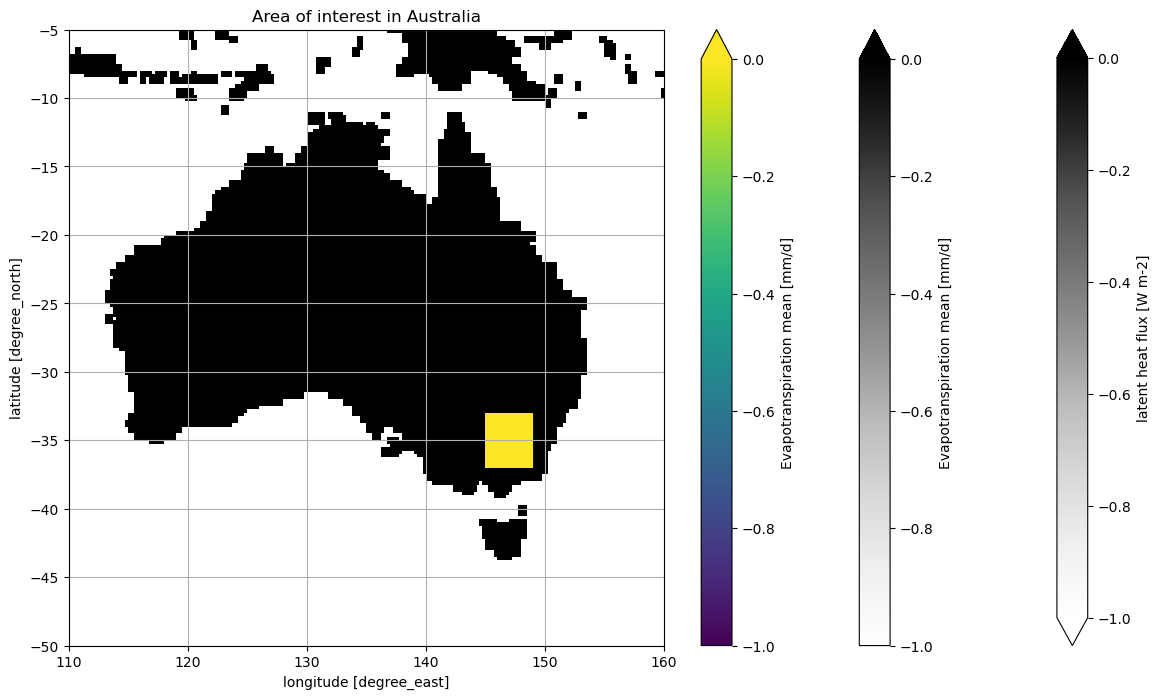

In [3]:
"""Lat: -37:-33, Lon: 145:149""" 

plt.figure(figsize = (15 , 8))
SA.hfls[1 , : , :].plot(cmap = 'Greys' , vmin = -1 , vmax = 0)
LFE_monthly.ET_mean[1].plot(cmap = 'Greys' , vmin = -1 , vmax = 0)
LFE_monthly.ET_mean[1 , -37+90:-33+90 , 145+180:149+180].plot(cmap = 'viridis' , vmin = -1 , vmax = 0)
plt.title(f'Area of interest in Australia')
plt.ylim(-50 , -5)
plt.xlim( 110 , 160)

plt.grid() 

In [4]:
"""Mean of the area"""

t = 120  #2001 - 2010

"""Days per month for the investigated time-series"""

dpm = [31, 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 29 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 29 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31,
      31 , 28 , 31 , 30 , 31 , 30 , 31 , 31 , 30 , 31 , 30 , 31]

#Only selecting the 2001-2010 and transposing the value into mm/month

dpm = np.array(dpm)
ET_mean_DOLCE_v3 = DOLCE_v3_monthly.hfls.mean(axis=(1, 2))[0:120] * dpm
ET_mean_FBP = FBP_monthly.Evaporation.mean(axis=(1, 2))[0:120] * dpm
ET_mean_UKESM1_0_LL = UKESM1_0_LL.mean(axis=(1, 2))[0:120] * dpm
ET_mean_EC_Earth3_veg = EC_Earth3_veg.mean(axis=(1, 2))[0:120] * dpm
ET_mean_CESM2 = CESM2.mean(axis=(1, 2))[0:120] * dpm
ET_mean_CMCC_ESM2 = CMCC_ESM2.mean(axis=(1, 2))[0:120] * dpm
ET_mean_E3SM_1_1 = E3SM_1_1.mean(axis=(1, 2))[0:120] * dpm
ET_mean_HadGEM3_GC31_LL = HadGEM3_GC31_LL.mean(axis=(1, 2))[0:120] * dpm
ET_mean_IPSL_CM6A_LR = IPSL_CM6A_LR.mean(axis=(1, 2))[0:120] * dpm
ET_mean_MIROC6 = MIROC6.mean(axis=(1, 2))[0:120] * dpm

"""Run-off"""    

R_UKESM1_0_LL = np.zeros(t)
R_CESM2 = np.zeros(t)
R_CMCC_ESM2 = np.zeros(t)
R_HadGEM3_GC31_LL = np.zeros(t)
R_IPSL_CM6A_LR = np.zeros(t)
R_MIROC6 = np.zeros(t)
R_E3SM_1_1 = np.zeros(t)
R_EC_Earth3_veg = np.zeros(t)
    
"""Converting to mm/month"""

for i in range(120):
    R_MIROC6[i] = 86400 * RO_MIROC6.mrro[612 + i].mean()*dpm[i]
    R_IPSL_CM6A_LR[i] = 86400 * RO_IPSL_CM6A_LR.mrro[612 + i].mean()*dpm[i]
    R_CESM2[i] = 86400 * RO_CESM2.mrro[612 + i].mean()*dpm[i]
    R_CMCC_ESM2[i] = 86400 * RO_CMCC_ESM2.mrro[1200+612 + i].mean()*dpm[i]
    R_HadGEM3_GC31_LL[i] = 86400 * RO_HadGEM3_GC31_LL.mrro[612 + i].mean()*dpm[i]
    R_UKESM1_0_LL[i] = 86400 * RO_UKESM1_0_LL.mrro[612 + i].mean()*dpm[i]
    R_E3SM_1_1[i] = 86400 * RO_E3SM_1_1.mrro[612 + i].mean()*dpm[i]
    R_EC_Earth3_veg[i] = 86400 * RO_EC_Earth3_veg.mrro[612 + i].mean()*dpm[i]

In [5]:
"""Precipitation"""

P_mean = np.zeros(t)

for i in range(len(P_mean)):
    P_mean[i] = Prec_monthly_2001_2010.pr[i].mean() * t_day * dpm[i]
    
p_01_10 = np.sum(P_mean[0:12]) + np.sum(P_mean[12:24]) + np.sum(P_mean[24:36]) + np.sum(P_mean[36:48]) + np.sum(P_mean[48:60]) + np.sum(P_mean[60:72]) + np.sum(P_mean[72:84]) + np.sum(P_mean[84:96]) + np.sum(P_mean[96:108]) + np.sum(P_mean[108:120])
print(f'The average yearly precipitation is equal to: {p_01_10/10:.2f} mm')

The average yearly precipitation is equal to: 544.96 mm


In [6]:
"""cum. P - E S"""

models_S = ['S_DOLCE_v3', 'S_FBP', 'S_UKESM1_0_LL', 'S_EC_Earth3_veg', 'S_CESM2', 'S_CMCC_ESM2', 'S_E3SM_1_1', 'S_HadGEM3_GC31_LL', 'S_IPSL_CM6A_LR', 'S_MIROC6']

for model in models_S:
    exec(f"{model} = np.zeros(t)") #Initialize all models with zeros
    for i in range(t):
        exec(f"{model}[i] = {model}[i - 1] + (P_mean[i] - ET_mean_{model[2:]}[i])")
        if eval(f"{model}[i] > 0"):
            exec(f"{model}[i] = 0")

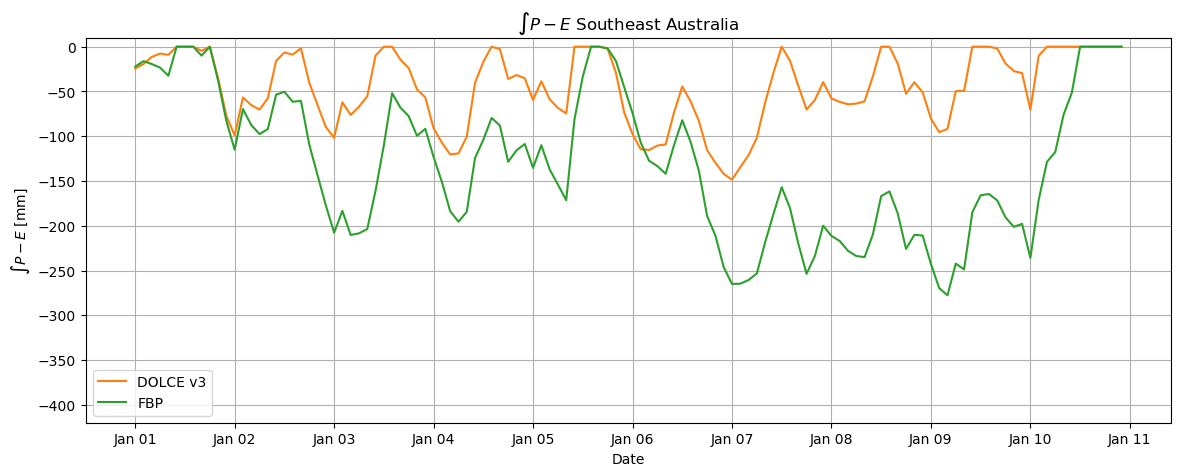

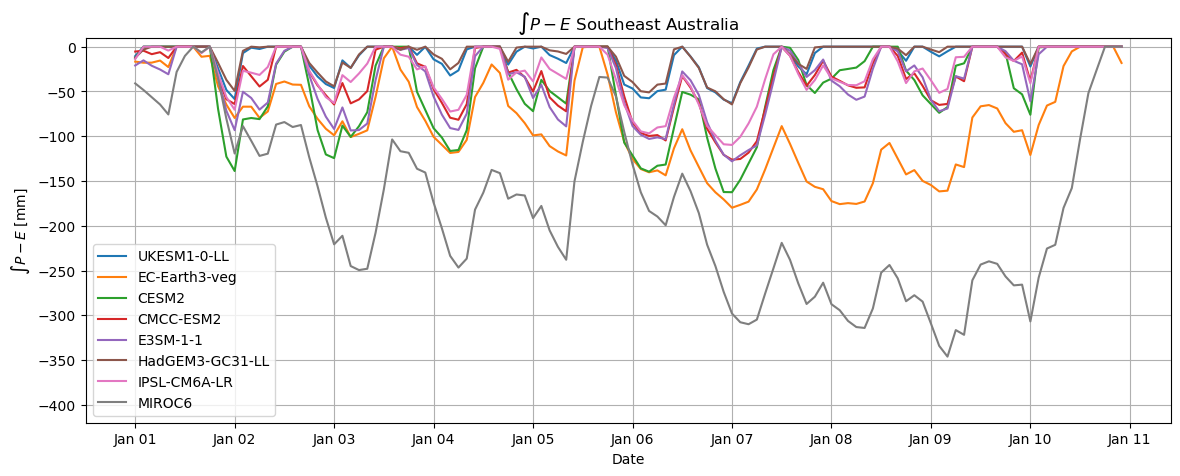

In [7]:
"""Benchmark products"""

plt.figure(figsize = (14 , 5))
plt.ylabel(r'$\int P - E $ [mm]')
#plt.plot(S1_LFE , label = 'Storage according to LFE')
plt.plot(S_DOLCE_v3 , label = 'DOLCE v3' , color= 'C1')
plt.plot(S_FBP , label = 'FBP' , color = 'C2')
plt.xticks(np.arange(0 , 121 , 12) , ['Jan 01' , 'Jan 02' ,'Jan 03' ,'Jan 04' ,'Jan 05' ,'Jan 06' ,'Jan 07' ,'Jan 08' ,'Jan 09' ,'Jan 10' , 'Jan 11'])
plt.xlabel('Date')
plt.title(r'$\int P - E $ Southeast Australia')
plt.grid()
plt.ylim(-420 , 10)
plt.legend();

S1 = [S_DOLCE_v3 , S_FBP, S_UKESM1_0_LL , S_EC_Earth3_veg , S_CESM2 ,  S_CMCC_ESM2 , S_E3SM_1_1 , S_HadGEM3_GC31_LL , S_IPSL_CM6A_LR , S_MIROC6]

"""LS3MIP"""

plt.figure(figsize = (14 , 5))
plt.ylabel(r'$\int P - E $ [mm]')
plt.plot(S_UKESM1_0_LL , label = 'UKESM1-0-LL')
plt.plot(S_EC_Earth3_veg , label = 'EC-Earth3-veg')
plt.plot(S_CESM2 , label = 'CESM2')
plt.plot(S_CMCC_ESM2 , label = 'CMCC-ESM2')
plt.plot(S_E3SM_1_1 , label = 'E3SM-1-1')
plt.plot(S_HadGEM3_GC31_LL , label = 'HadGEM3-GC31-LL')
plt.plot(S_IPSL_CM6A_LR , label = 'IPSL-CM6A-LR')
plt.plot(S_MIROC6 , label = 'MIROC6')
plt.xlabel('Date')
plt.ylim(-420 , 10)
plt.title(r'$\int P - E $ Southeast Australia')
plt.xticks(np.arange(0 , 121 , 12) , ['Jan 01' , 'Jan 02' ,'Jan 03' ,'Jan 04' ,'Jan 05' ,'Jan 06' ,'Jan 07' ,'Jan 08' ,'Jan 09' ,'Jan 10' , 'Jan 11'])
plt.grid()
plt.legend();

In [8]:
"""P - E per month"""

model_P_E = ['P_ET_DOLCE_v3', 'P_ET_FBP', 'P_ET_UKESM1_0_LL', 'P_ET_EC_Earth3_veg', 'P_ET_CESM2', 'P_ET_CMCC_ESM2', 'P_ET_E3SM_1_1', 'P_ET_HadGEM3_GC31_LL', 'P_ET_IPSL_CM6A_LR', 'P_ET_MIROC6']

for model in model_P_E:
    exec(f"{model} = np.zeros(t)")
    for i in range(t):
        exec(f"{model}[i] = {model}[i - 1] + (P_mean[i] - ET_mean_{model[5:]}[i])")
        if eval(f"{model}[i] > 0"):
            exec(f"{model}[i] = 0")

In [9]:
"""P - E response anomolies"""


"""Precipitation"""

P_pm_mean = np.zeros(12)
P_an = np.zeros(120)
mpy = np.arange(0 , 120 , 12)

for i in range(12):
    #Array per month average
    P_pm_mean[i] = np.mean([P_mean[i] , P_mean[i + 12] , P_mean[i + 24] ,  P_mean[i+36] , 
    P_mean[i + 48] , P_mean[i + 60] , P_mean[i + 72] , P_mean[i + 84] , P_mean[i + 96] , 
    P_mean[i + 108]])
    
for j in range(len(mpy)):   
    for i in range(12):
        P_an[mpy[j] + i] = P_mean[mpy[j]+i] - P_pm_mean[i]


"""Evapotranspiration"""

ET_mean = [ET_mean_DOLCE_v3 , ET_mean_FBP, ET_mean_UKESM1_0_LL , ET_mean_EC_Earth3_veg , ET_mean_CESM2 ,  ET_mean_CMCC_ESM2 , ET_mean_E3SM_1_1 , ET_mean_HadGEM3_GC31_LL , ET_mean_IPSL_CM6A_LR , ET_mean_MIROC6]
ET_pm_mean = np.zeros((10 , 12))

for j in range(len(ET_mean)):
    for i in range(12):
        #Array per month average
        ET_pm_mean[j , i] = np.mean([ET_mean[j][i] , ET_mean[j][i + 12] , ET_mean[j][i + 24] ,  ET_mean[j][i+36] , 
        ET_mean[j][i + 48] , ET_mean[j][i + 60] , ET_mean[j][i + 72] , ET_mean[j][i + 84] , ET_mean[j][i + 96] , 
        ET_mean[j][i + 108]])

ET_an = np.zeros((10 , 120))
mpy = np.arange(0 , 120 , 12)

for m in range(len(ET_mean)):
    for j in range(len(mpy)):   
        for i in range(12):
            ET_an[m][mpy[j] + i] = ET_mean[m][mpy[j]+i] - ET_pm_mean[m][i]

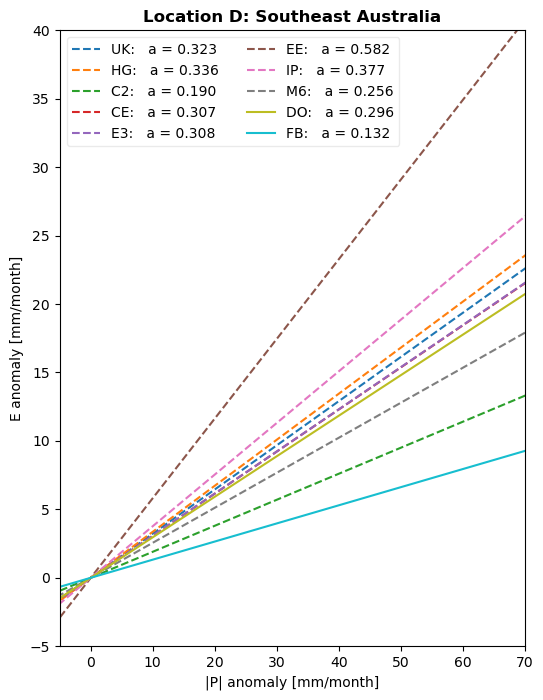

In [10]:
"""Linear function"""

d = {'P_mean': P_an, 'UKESM1-0-LL_ET' : ET_an[2] , 'EC-Earth3-veg_ET' : ET_an[3] , 'CESM2_ET' : ET_an[4] , 'CMCC-ESM2_ET':ET_an[5] 
     ,'E3SM-1-1_ET':ET_an[6] , 'HadGEM3-GC31-LL_ET' : ET_an[7] , 'IPSL-CM6A-LR_ET':ET_an[8] , 'MIROC6_ET':ET_an[9] , 'DOLCE_v3_ET' : ET_an[0]
     , 'FBP_ET':ET_an[1]}
df = pd.DataFrame(d)
df = df.sort_values(by = ['P_mean'])

def func(x, a , b):
    return a * x + b

label_a = ['UK'  ,  'HG' , 'C2' , 'CE' , 'E3'  , 'EE' , 'IP' , 'M6' , 'DO' , 'FB']
label = ['UKESM1-0-LL'  ,  'HadGEM3-GC31-LL' , 'CESM2' , 'CMCC-ESM2' , 'E3SM-1-1'  , 'EC-Earth3-veg' , 'IPSL-CM6A-LR' , 'MIROC6' , 'DOLCE_v3' , 'FBP']
y = df['UKESM1-0-LL_ET'] , df['HadGEM3-GC31-LL_ET'] , df['CESM2_ET'] , df['CMCC-ESM2_ET'] , df['E3SM-1-1_ET'] , df['EC-Earth3-veg_ET'] , df['IPSL-CM6A-LR_ET'] , df['MIROC6_ET'] , df['DOLCE_v3_ET'] , df['FBP_ET']
linestyle = ['dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'solid' , 'solid']
S = np.zeros(len(label))
a = np.zeros(len(label))

plt.figure(figsize = (6 , 8))

for i in range(len(label)):
    xdata = df['P_mean']
    ydata = y[i]
    popt , pcov  = curve_fit(func , xdata, ydata)
    S[i] = func(xdata[0] , *popt)
    a[i] = popt[0]
    plt.plot(xdata , func(xdata, *popt) , label = f'{label_a[i]}:   a = {a[i]:.3f}' , linestyle = linestyle[i]);


#Adjust xlim and ylim manually if needed    

plt.title('Location D: Southeast Australia' , fontweight = 'bold')
plt.ylim(-5 , 40)
#plt.grid()
plt.xlim(-5 , 70)
plt.ylabel('E anomaly [mm/month]')
plt.xlabel('|P| anomaly [mm/month]')
plt.legend(framealpha = 0.4 , ncols = 2);

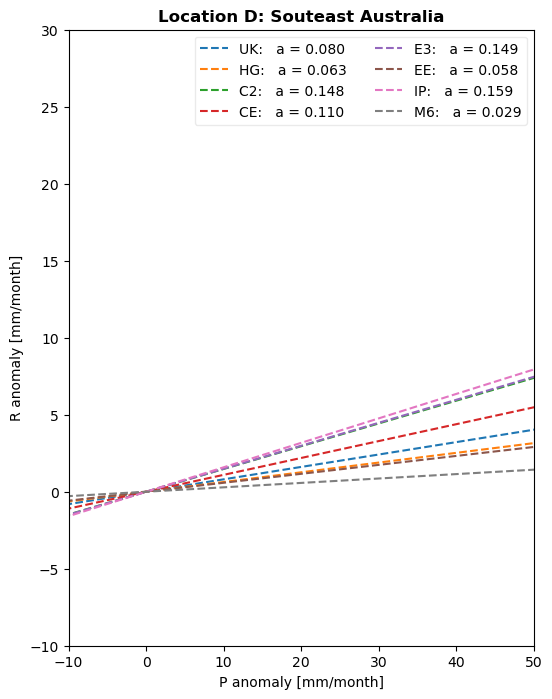

In [11]:
"""P - R response anomolies"""

"""Run-off"""

R_mean = [R_UKESM1_0_LL , R_EC_Earth3_veg , R_CESM2 ,  R_CMCC_ESM2 , R_E3SM_1_1 , R_HadGEM3_GC31_LL , R_IPSL_CM6A_LR , R_MIROC6]
R_pm_mean = np.zeros((8 , 12))

for j in range(len(R_mean)):
    for i in range(12):
        #Array per month average
        R_pm_mean[j , i] = np.mean([R_mean[j][i] , R_mean[j][i + 12] , R_mean[j][i + 24] ,  R_mean[j][i+36] , 
        R_mean[j][i + 48] , R_mean[j][i + 60] , R_mean[j][i + 72] , R_mean[j][i + 84] , R_mean[j][i + 96] , 
        R_mean[j][i + 108]])

R_an = np.zeros((10 , 120))
mpy = np.arange(0 , 120 , 12)

for m in range(len(R_mean)):
    for j in range(len(mpy)):   
        for i in range(12):
            R_an[m][mpy[j] + i] = R_mean[m][mpy[j]+i] - R_pm_mean[m][i]
            
"""Linear function"""

d = {'P_mean': P_an, 'UKESM1-0-LL' : R_an[0] , 'EC-Earth3-veg' : R_an[1] , 'CESM2' : R_an[2] , 'CMCC-ESM2':R_an[3] 
     ,'E3SM-1-1':R_an[4] , 'HadGEM3-GC31-LL' : R_an[5] , 'IPSL-CM6A-LR':R_an[6] , 'MIROC6':R_an[7]}
df = pd.DataFrame(d)
df = df.sort_values(by = ['P_mean'])

def func(x, a , b):
    return a * x + b

label_a = ['UK'  ,  'HG' , 'C2' , 'CE' , 'E3'  , 'EE' , 'IP' , 'M6']
label = ['UKESM1-0-LL'  ,  'HadGEM3-GC31-LL' , 'CESM2' , 'CMCC-ESM2' , 'E3SM-1-1'  , 'EC-Earth3-veg' , 'IPSL-CM6A-LR' , 'MIROC6']
y = df['UKESM1-0-LL'] , df['HadGEM3-GC31-LL'] , df['CESM2'] , df['CMCC-ESM2'] , df['E3SM-1-1'] , df['EC-Earth3-veg'] , df['IPSL-CM6A-LR'] , df['MIROC6']
linestyle = ['dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed']
S = np.zeros(len(label))
a = np.zeros(len(label))

plt.figure(figsize = (6 , 8))

for i in range(len(label)):
    xdata = df['P_mean']
    ydata = y[i]
    popt , pcov  = curve_fit(func , xdata, ydata)
    S[i] = func(xdata[0] , *popt)
    a[i] = popt[0]
    plt.plot(xdata , func(xdata, *popt) , label = f'{label_a[i]}:   a = {a[i]:.3f}' , linestyle = linestyle[i]);


#Adjust xlim and ylim manually if needed    

plt.title('Location D: Souteast Australia' , fontweight = 'bold')
plt.ylim(-10 , 30)
#plt.grid()
plt.xlim(-10 , 50)
plt.ylabel('R anomaly [mm/month]')
plt.xlabel('P anomaly [mm/month]')
plt.legend(framealpha = 0.4 , ncols = 2);

------------------------------------------------
Climate Model
------------------------------------------------
The mean monthly E is: 30.279 from UKESM1-0-LL
The mean monthly E is: 43.321 from EC-Earth3-veg
The mean monthly E is: 33.806 from CESM2
The mean monthly E is: 36.454 from CMCC-ESM2
The mean monthly E is: 37.123 from E3SM-1-1
The mean monthly E is: 29.578 from HadGEM3-GC31-LL
The mean monthly E is: 37.038 from IPSL-CM6A-LR
The mean monthly E is: 44.412 from MIROC6
------------------------------------------------
Benchmark product
------------------------------------------------
The mean monthly E is: 38.834 from DOLCE v3
The mean monthly E is: 42.614 from FBP



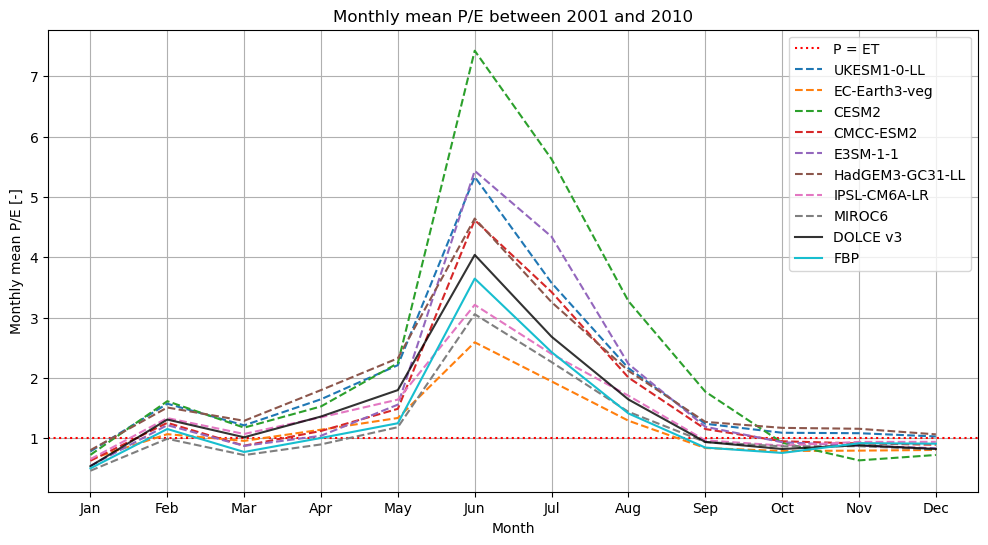

In [12]:
"""Comparing yearly P/E for every model"""

label = ['DOLCE_v3' , 'FBP' , 'UKESM1-0-LL' , 'EC-Earth3-veg' , 'CESM2' , 'CMCC-ESM2' , 'E3SM-1-1' , 'HadGEM3-GC31-LL' , 'IPSL-CM6A-LR' , 'MIROC6']

plt.figure(figsize= (12 ,6))
plt.axhline(y = 1 , xmin = 0 , xmax = 1 , color = 'red' , linestyle = 'dotted' , alpha = 1 , label = 'P = ET')
plt.grid()
plt.xlabel('Month')
plt.ylabel('Monthly mean P/E [-]')
plt.title('Monthly mean P/E between 2001 and 2010')

for i in range(2 , 10):
    plt.plot(P_pm_mean/ET_pm_mean[i] , label = label[i] , linestyle = 'dashed')

plt.plot(P_pm_mean/ET_pm_mean[0] , label = 'DOLCE v3' , color = 'k' , alpha = 0.8)
plt.plot(P_pm_mean/ET_pm_mean[1] , label = 'FBP' , color = 'C9')
#plt.plot(P_pm_mean , 'bd-' , label = 'GWSP3 P', alpha = 0.4)
plt.xticks(np.arange(0 , 12 , 1) , ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'Jun' , 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec'])

plt.legend();

"""Average state of ET"""

print('----' * 12)
print('Climate Model')
print('----' * 12)

for i in range(2 , 10):
    print(f'The mean monthly E is: {ET_pm_mean[i].mean():.3f} from {label[i]}')

print('----' * 12)
print('Benchmark product')
print('----' * 12)
print(f'The mean monthly E is: {ET_pm_mean[0].mean():.3f} from DOLCE v3')
print(f'The mean monthly E is: {ET_pm_mean[1].mean():.3f} from FBP')
print()

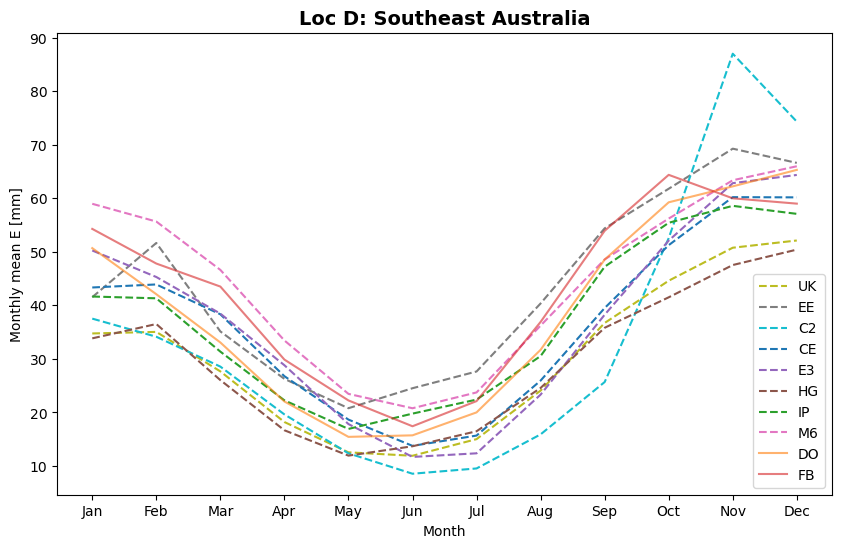

In [38]:
plt.figure(figsize= (10 ,6))
#plt.grid()
plt.xlabel('Month')
plt.ylabel('Monthly mean E [mm]')
plt.title('Loc D: Southeast Australia' , fontweight = 'bold' , fontsize = 14)

label = ['UK' , 'EE' , 'C2' , 'CE' , 'E3' , 'HG' , 'IP' , 'M6' , 'DO' , 'FB']
color = ['C8' , 'C7' , 'C9' , 'C10', 'C4' , 'C5' , 'C2' , 'C6' , 'C1' , 'C3']

for i in range(0 , 8):
    plt.plot(ET_pm_mean[i + 2] , label = label[i], color = color[i] , linestyle = 'dashed')

plt.plot(ET_pm_mean[0] , label = 'DO' , color = 'C1' , alpha = 0.6)
plt.plot(ET_pm_mean[1] , label = 'FB' , color = 'C3' , alpha = 0.6)
#plt.plot(P_pm_mean , 'bd-' , label = 'GWSP3 P', alpha = 0.4)
plt.xticks(np.arange(0 , 12 , 1) , ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'Jun' , 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec']);

plt.legend();

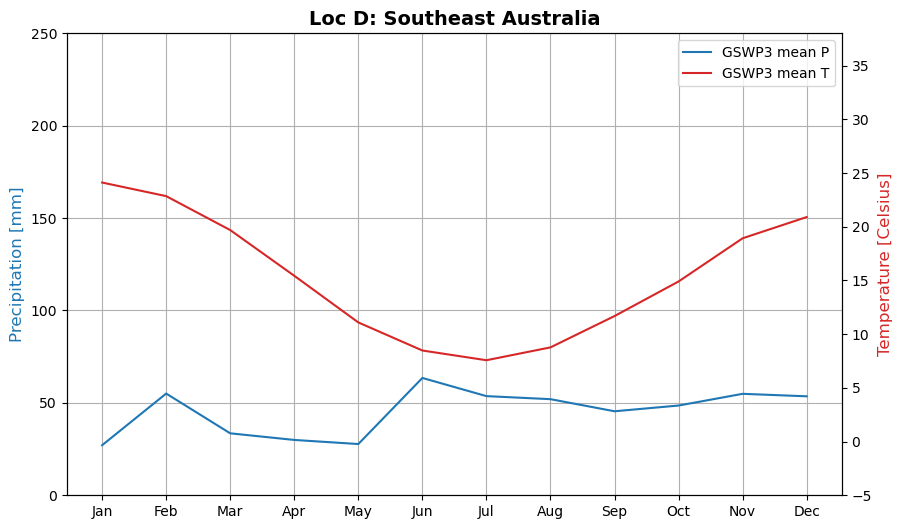

In [14]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize = (10 , 6))

# Create second axis ax2 that shares the x-axis with ax1
ax2 = ax1.twinx()

#WA

t = 3652

Tas_mean = np.zeros(t)

for i in range(t):
    Tas_mean[i] = Tas.tas[i , : , :].mean()
    
data = Tas_mean
avg = np.zeros(12)
    

# Create an empty dictionary to store the monthly averages
monthly_averages = defaultdict(list)

# loop through the data and group the values by month
for i, value in enumerate(data):
    date = datetime.datetime(2001, 1, 1) + datetime.timedelta(i)
    if date.year >= 2001 and date.year <= 2010:
        month = date.month
        monthly_averages[month].append(value)

# calculate the mean for each month
for month, values in monthly_averages.items():
    avg[month - 1] = sum(values) / len(values)
    
# Plot the data and store the line objects
P, = ax1.plot(P_pm_mean, color = 'C0', label = 'GSWP3 mean P')
T, = ax2.plot(avg - 273.15, color = 'C3', label = 'GSWP3 mean T')

# Set the x-ticks
ax1.set_xticks(np.arange(0, 12, 1))

# Set the x-tick labels
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Set the y-axis labels
ax1.set_ylabel('Precipitation [mm]', color='C0' , fontsize = 12)
ax2.set_ylabel('Temperature [Celsius]', color='C3' , fontsize = 12)

ax2.set_ylim(-5 , 38)
ax1.set_ylim(0 , 250)

# Create the legend
ax1.legend([P, T], ['GSWP3 mean P', 'GSWP3 mean T'], loc='best')
ax1.grid(True)

plt.title('Loc D: Southeast Australia' , fontweight = 'bold' , fontsize = 14);

In [15]:
"""Seasonality index"""

P_annual = np.sum(P_pm_mean)
SI = np.zeros(len(P_pm_mean))

for i in range(12):
    SI[i] = (1 / P_annual) * np.abs(P_pm_mean[i] - (P_annual/12))
    
print(f'The SI is equal to: {np.sum(SI):.2f}')

The SI is equal to: 0.23


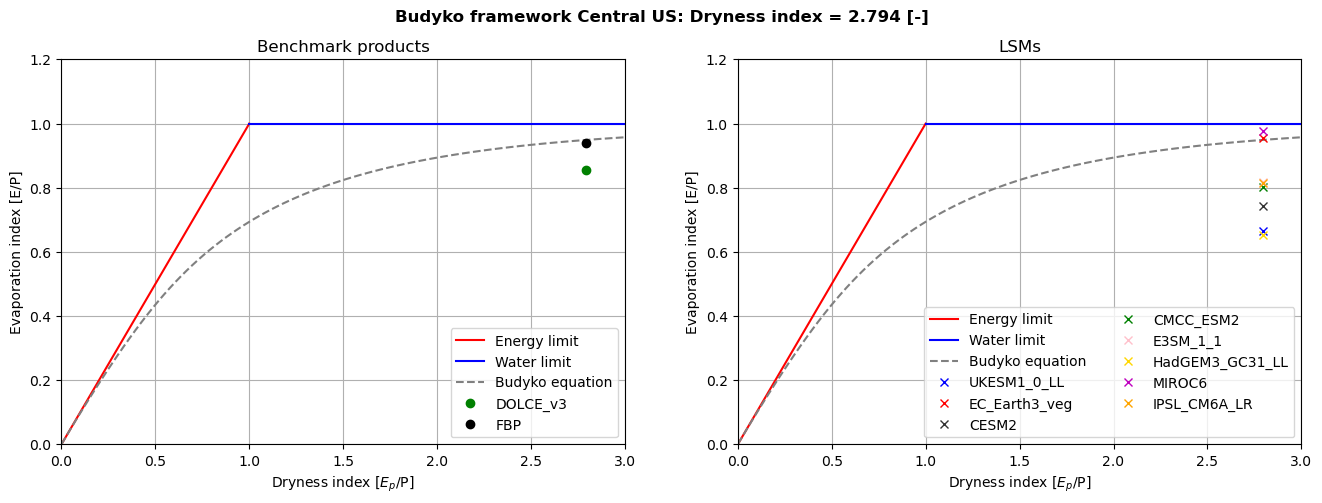

In [16]:
"""EP_0"""

def EP_HS(J, lat ,Tmax,Tmin,Tav):
    # extraterrestrial radation
    G = 0.0820  #MJ m^-2 min^-1
    phi = lat/360 * (2*np.pi) #rad
    d = 1 + 0.033 * np.cos(0.0172 * J) #[-]
    delta = 0.409 * np.sin(0.0172 * J - 1.39) #rad
    w = np.arccos(-np.tan(phi)*np.tan(delta)) #rad
    Re = (24*60)/np.pi * G * d * (w*np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta)*np.sin(w)) #MJ m^-2 d^-1
    
    # Hargreaves and Samani EP
    labda = 2.45 # MJ kg^-1
    alpha = 0.0023
    Ep = (1/labda) * alpha * Re * (Tav + 17.8) * np.sqrt(Tmax-Tmin) #convert to mm
    if(Ep<0):
        Ep=0
    return(Ep)

EP_0 = np.zeros(365)

for i in range(365):
    EP_0[i] = EP_HS(i+1 , -14 , Tmax[i , : , :].mean()-273.15 , Tmin[i , : , :].mean()-273.15 , Tav[i , : , :].mean()-273.15) * (365.2 / 12)

"""Budyko framework"""

x = [0 , 1]
y = [0 , 1]
y2 = [1 , 1]
x2 = [1 , 3]

plt.figure(figsize = (16 , 5))
plt.subplot(121)
plt.plot(x , y , 'r' , label = 'Energy limit')
plt.plot(x2 , y2 , 'blue' , label = 'Water limit')


"""Budyko equation"""

xb = np.linspace(0.001 , 3 , 100)
yb = np.sqrt(xb * (1 - np.exp(-xb))*np.tanh(xb**-1))
plt.plot(xb , yb , label = 'Budyko equation' , linestyle = 'dashed' , color = 'grey')

"""Models"""

plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_DOLCE_v3.mean()/ P_mean.mean() , 'go' , label = 'DOLCE_v3')
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_FBP.mean()/ P_mean.mean() , 'ko' , label = 'FBP')

plt.xlabel(r'Dryness index [$E_p$/P]')
plt.ylabel('Evaporation index [E/P]')
plt.title('Benchmark products')
plt.grid()
plt.legend()
plt.ylim(0 , 1.2)
plt.xlim(0 , 3)

plt.subplot(122)
plt.plot(x , y , 'r' , label = 'Energy limit')
plt.plot(x2 , y2 , 'blue' , label = 'Water limit')

xb = np.linspace(0.001 , 3 , 100)
yb = np.sqrt(xb * (1 - np.exp(-xb))*np.tanh(xb**-1))
plt.plot(xb , yb , label = 'Budyko equation' , linestyle = 'dashed' , color = 'grey')

plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_UKESM1_0_LL.mean()/ P_mean.mean() , 'bx' , label = 'UKESM1_0_LL')
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_EC_Earth3_veg.mean()/ P_mean.mean() , 'rx' , label = 'EC_Earth3_veg')
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_CESM2.mean()/ P_mean.mean() , 'kx' , label = 'CESM2' , alpha = 0.8)
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_CMCC_ESM2.mean()/ P_mean.mean() , linestyle = (0 , (0 , 100)) , marker = 'x' , color = 'green',  label = 'CMCC_ESM2')
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_E3SM_1_1.mean()/ P_mean.mean() ,linestyle = (0 , (0 , 100)), color = 'pink' , marker = 'x' , label = 'E3SM_1_1')
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_HadGEM3_GC31_LL.mean()/ P_mean.mean() , linestyle = (0 , (0 , 100)) , color = 'gold' , marker = 'x' , label = 'HadGEM3_GC31_LL')
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_MIROC6.mean()/ P_mean.mean() , 'mx' , label = 'MIROC6')
plt.plot(EP_0.mean()/P_mean.mean() , ET_mean_IPSL_CM6A_LR.mean()/ P_mean.mean() ,linestyle = (0 , (0 , 100)), color = 'orange' , marker = 'x' , label = 'IPSL_CM6A_LR')

plt.xlabel(r'Dryness index [$E_p$/P]')
plt.ylabel('Evaporation index [E/P]')
plt.title('LSMs')
plt.suptitle(f'Budyko framework Central US: Dryness index = {EP_0.mean()/P_mean.mean():.3f} [-]' , fontweight = 'bold')
plt.grid()
plt.ylim(0 , 1.2)
plt.xlim(0 , 3)
plt.legend(ncols = 2);

-----------------------------------------------------------------------------------------------
The maximum decrease in storage in 2003/2004                 is equal to:           -4.743 mm
The decrease in layer 1 (0 - 10 cm)                          is equal to:           1.091 mm
The decrease in layer 1 (10 - 30 cm)                         is equal to:           -1.940 mm
The decrease in layer 1 (30 - 50 cm)                         is equal to:           -3.894 mm
-----------------------------------------------------------------------------------------------


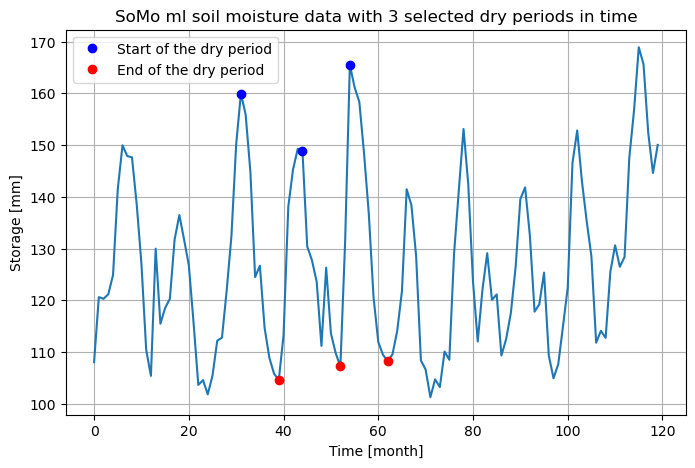

In [17]:
#Picking some dry periods (manually)

Storage = L1 * 0.1 + L2 * 0.2 + L3 * 0.2
Storage = Storage * 1000 #convert to mm


plt.figure(figsize = (8 , 5))

plt.plot(Storage)
plt.plot(31 , Storage[31] , 'bo' , label = 'Start of the dry period')
plt.plot(39 , Storage[39] , 'ro' , label = 'End of the dry period')

plt.plot(54 , Storage[54] , 'bo')
plt.plot(62 , Storage[62] , 'ro')

plt.plot(44 , Storage[44] , 'bo')
plt.plot(52 , Storage[52] , 'ro')



plt.grid()

plt.legend()
plt.title('SoMo ml soil moisture data with 3 selected dry periods in time')
plt.ylabel('Storage [mm]')
plt.xlabel('Time [month]')

print('-----' * 19)
print(f'The maximum decrease in storage in 2003/2004                 is equal to:           {Storage[28] - Storage[35]:.3f} mm')
print(f'The decrease in layer 1 (0 - 10 cm)                          is equal to:           {(L1[28] - L1[35])*100:.3f} mm')
print(f'The decrease in layer 1 (10 - 30 cm)                         is equal to:           {(L2[28] - L2[35])*200:.3f} mm')
print(f'The decrease in layer 1 (30 - 50 cm)                         is equal to:           {(L3[28] - L3[35])*200:.3f} mm')
print('-----' * 19)

In [18]:
"""For the period 2005/2006"""

'For the period 2005/2006'

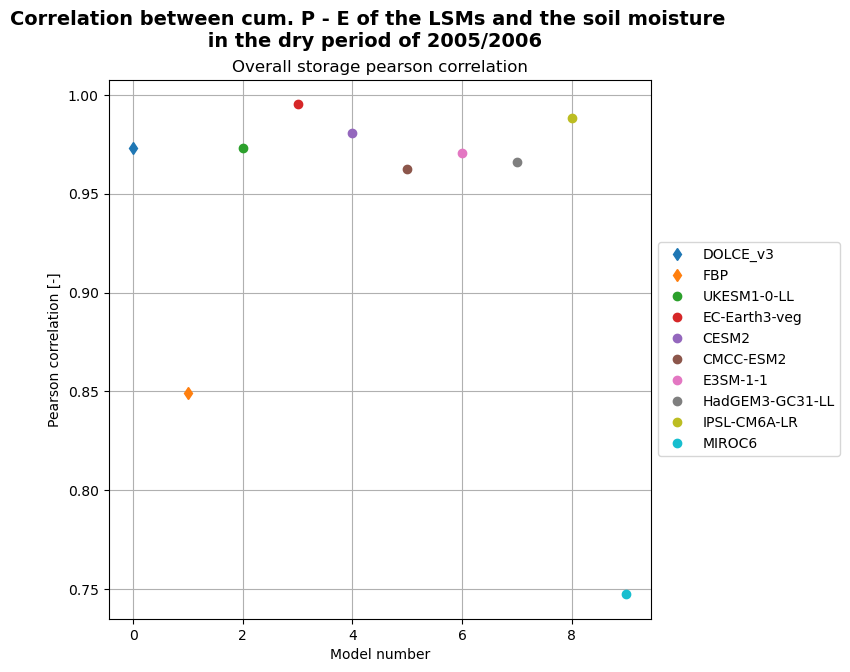

In [19]:
"""Manually put in selected dry period"""

plt.figure(figsize = (7 , 7))

label = ['DOLCE_v3' , 'FBP' ,'UKESM1-0-LL' , 'EC-Earth3-veg' , 'CESM2' , 'CMCC-ESM2' , 'E3SM-1-1' , 'HadGEM3-GC31-LL' , 'IPSL-CM6A-LR' , 'MIROC6']
S = [S_DOLCE_v3 , S_FBP , S_UKESM1_0_LL  , S_EC_Earth3_veg , S_CESM2, S_CMCC_ESM2 , S_E3SM_1_1 , S_HadGEM3_GC31_LL , S_IPSL_CM6A_LR , S_MIROC6]
marker = ['d' , 'd' , 'o' , 'o' , 'o' , 'o' , 'o' , 'o' , 'o' , 'o']

for i in range(len(models_S)):
    x = S[i][54:63]
    y = Storage[54:63]
    pearsonr = scipy.stats.pearsonr(x, y)
    plt.plot(i , pearsonr[0] , marker = marker[i] , linestyle = (0 , (0 , 100)) , label = label[i])
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Overall storage pearson correlation')
plt.ylabel('Pearson correlation [-]')
#plt.xticks(np.arange(0,10,1) , ['DOLCE_v3' , 'FBP' ,'UKESM1-0-LL' , 'EC-Earth3-veg' , 'CESM2' , 'CMCC-ESM2' , 'E3SM-1-1' , 'HadGEM3-GC31-LL' , 'IPSL-CM6A-LR' , 'MIROC6'])
plt.xlabel('Model number')
plt.grid()

plt.suptitle('Correlation between cum. P - E of the LSMs and the soil moisture \n in the dry period of 2005/2006' , fontsize = 14 ,fontweight = 'bold');

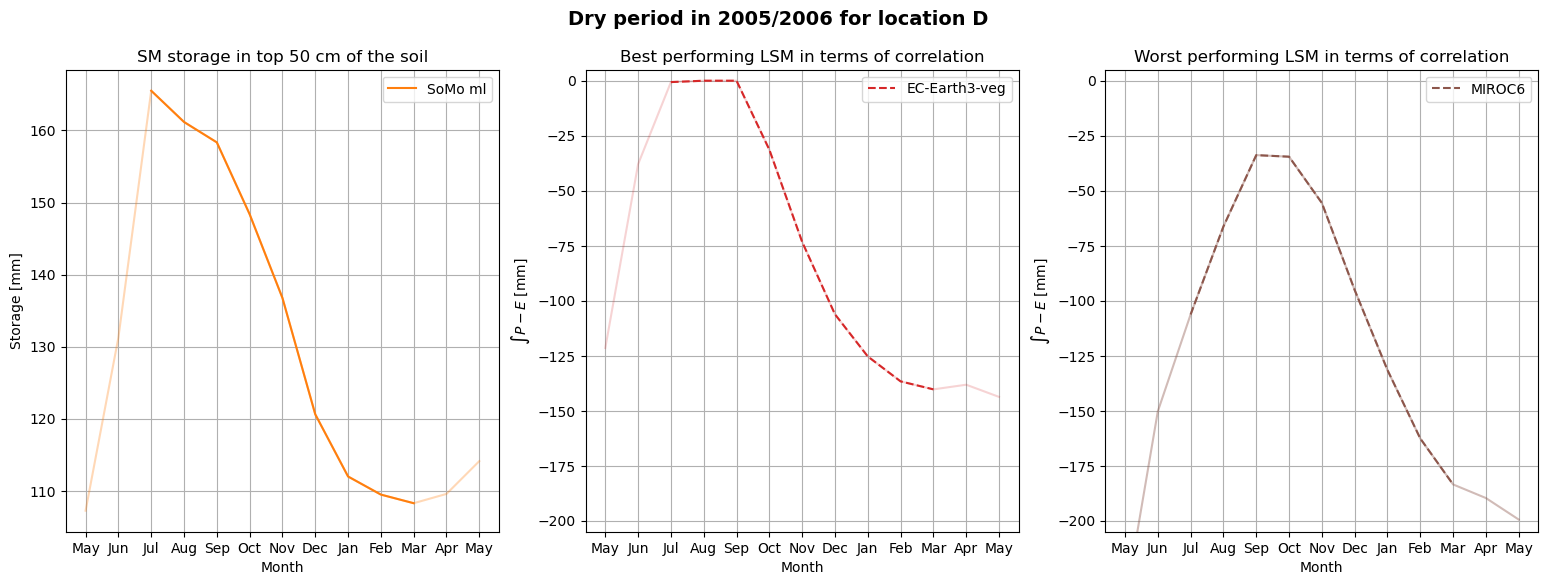

In [20]:
plt.figure(figsize = (19 , 6))

plt.subplot(131)
plt.plot(Storage[52:65] , color = 'C1' , alpha = 0.3)
plt.plot([2, 3 , 4 , 5 , 6 , 7 , 8 ,9 , 10] , Storage[54:63] , color = 'C1' , label = 'SoMo ml')
plt.title('SM storage in top 50 cm of the soil')
plt.xlabel('Month')
plt.ylabel('Storage [mm]')
plt.xticks([0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12] , ['May' , 'Jun', 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec' , 'Jan' , 'Feb' , 'Mar' , 'Apr' , 'May']) #Fix this for the right months
plt.grid()
plt.legend()

plt.subplot(132)
plt.plot(S_EC_Earth3_veg[52:65] , color = 'C3' , alpha = 0.2)
#plt.plot(S_FBP[26:37] , color = 'C3' , alpha = 0.2)
plt.plot([2, 3 , 4 , 5 , 6 , 7 , 8 ,9 , 10] , S_EC_Earth3_veg[54:63] , color = 'C3' , label = 'EC-Earth3-veg' , linestyle = 'dashed')
#plt.plot([2 , 3 , 4 , 5 , 6 , 7 , 8] , S_FBP[28:35] , color = 'C3' , label = 'FBP')
plt.title('Best performing LSM in terms of correlation')
plt.ylabel(r'$\int P - E $ [mm]')
plt.xlabel('Month')
plt.ylim(-205 , 5)
plt.xticks([0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12] , ['May' , 'Jun', 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec' , 'Jan' , 'Feb' , 'Mar' , 'Apr' , 'May'])
plt.grid()
plt.legend()

plt.subplot(133)

plt.plot(S_MIROC6[52:65] , color = 'C5' , alpha = 0.4)
plt.plot([2, 3 , 4 , 5 , 6 , 7 , 8 ,9 , 10] , S_MIROC6[54:63] , color = 'C5' , label = 'MIROC6' , linestyle = 'dashed')
plt.title('Worst performing LSM in terms of correlation')
plt.ylabel(r'$\int P - E $ [mm]')
plt.xticks([0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12] , ['May' , 'Jun', 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec' , 'Jan' , 'Feb' , 'Mar' , 'Apr' , 'May'])
plt.xlabel('Month')
plt.ylim(-205 , 5)
plt.grid()
plt.legend();

plt.suptitle('Dry period in 2005/2006 for location D', fontsize = 14 ,fontweight = 'bold');
print()

In [21]:
#For the selected year calculate the difference in cumulative P - E

print()
print(colored(f'The maximum decrease in cum. P - E between summer 2005 and Spring 2006' , 'blue'))

print('----' * 24)

print(f'The maximum decrease in cum. P - E for  MIROC6          is equal to:           {S_MIROC6[54] - S_MIROC6[62]:.3f} mm')
print(f'The maximum decrease in cum. P - E for  UKESM1_0_LL     is equal to:           {S_UKESM1_0_LL[54] - S_UKESM1_0_LL[62]:.3f} mm')
print(f'The maximum decrease in cum. P - E for  CESM2           is equal to:           {S_CESM2[54] - S_CESM2[62]:.3f} mm')
print(f'The maximum decrease in cum. P - E for  HadGEM-GC31-LL  is equal to:           {S_HadGEM3_GC31_LL[54] - S_HadGEM3_GC31_LL[62]:.3f} mm')

print(f'The maximum decrease in cum. P - E for  EC_Earth3_veg   is equal to:           {S_EC_Earth3_veg[54] - S_EC_Earth3_veg[62]:.3f} mm')
print(f'The maximum decrease in cum. P - E for  CMCC-ESM2       is equal to:           {S_CMCC_ESM2[54] - S_CMCC_ESM2[62]:.3f} mm')
print(f'The maximum decrease in cum. P - E for  E3SM-1-1        is equal to:           {S_E3SM_1_1[54] - S_E3SM_1_1[62]:.3f} mm')
print(f'The maximum decrease in cum. P - E for  IPSL-CM6A-LR    is equal to:           {S_IPSL_CM6A_LR[54] - S_IPSL_CM6A_LR[62]:.3f} mm')

print('----' * 24)

print(f'The maximum decrease in cum. P - E for  FBP             is equal to:           {S_FBP[54] - S_FBP[63]:.3f} mm')
print(f'The maximum decrease in cum. P - E for  DOLCE v3        is equal to:           {S_DOLCE_v3[54] - S_DOLCE_v3[63]:.3f} mm')


The maximum decrease in cum. P - E between summer 2005 and Spring 2006
------------------------------------------------------------------------------------------------
The maximum decrease in cum. P - E for  MIROC6          is equal to:           77.262 mm
The maximum decrease in cum. P - E for  UKESM1_0_LL     is equal to:           57.602 mm
The maximum decrease in cum. P - E for  CESM2           is equal to:           139.637 mm
The maximum decrease in cum. P - E for  HadGEM-GC31-LL  is equal to:           51.063 mm
The maximum decrease in cum. P - E for  EC_Earth3_veg   is equal to:           139.672 mm
The maximum decrease in cum. P - E for  CMCC-ESM2       is equal to:           99.754 mm
The maximum decrease in cum. P - E for  E3SM-1-1        is equal to:           103.030 mm
The maximum decrease in cum. P - E for  IPSL-CM6A-LR    is equal to:           96.829 mm
------------------------------------------------------------------------------------------------
The maximum decreas

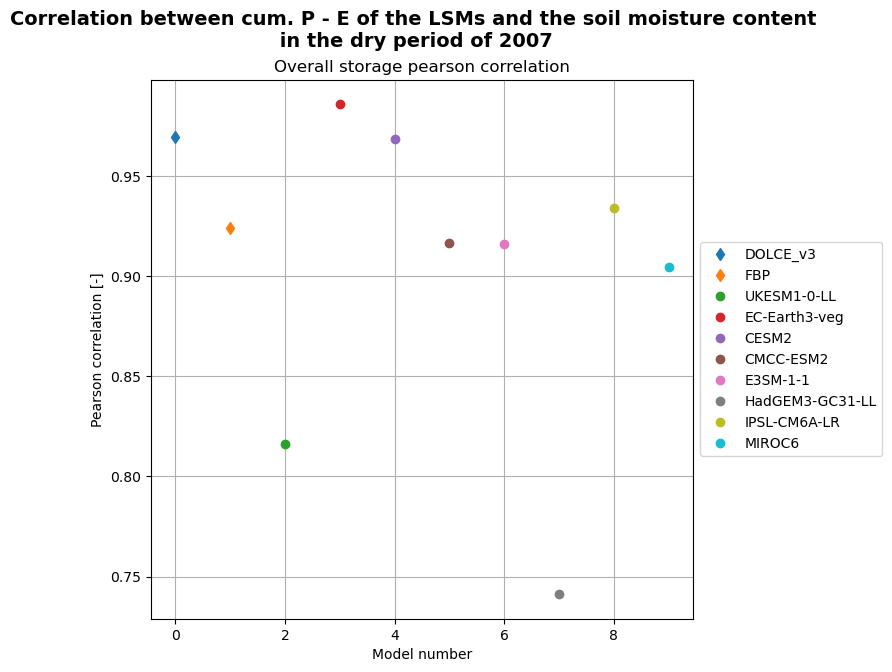

In [22]:
"""For the year 2007"""

"""Select a second dry period"""

plt.figure(figsize = (7 , 7))

label = ['DOLCE_v3' , 'FBP' ,'UKESM1-0-LL' , 'EC-Earth3-veg' , 'CESM2' , 'CMCC-ESM2' , 'E3SM-1-1' , 'HadGEM3-GC31-LL' , 'IPSL-CM6A-LR' , 'MIROC6']
S = [S_DOLCE_v3 , S_FBP , S_UKESM1_0_LL  , S_EC_Earth3_veg , S_CESM2, S_CMCC_ESM2 , S_E3SM_1_1 , S_HadGEM3_GC31_LL , S_IPSL_CM6A_LR , S_MIROC6]
marker = ['d' , 'd' , 'o' , 'o' , 'o' , 'o' , 'o' , 'o' , 'o' , 'o']

for i in range(len(models_S)):
    x = S[i][31:39]
    y = Storage[31:39]
    pearsonr = scipy.stats.pearsonr(x, y)
    plt.plot(i , pearsonr[0] , marker = marker[i] , linestyle = (0 , (0 , 100)) , label = label[i])
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Overall storage pearson correlation')
plt.ylabel('Pearson correlation [-]')
plt.xlabel('Model number')
plt.grid()

plt.suptitle('Correlation between cum. P - E of the LSMs and the soil moisture content\n in the dry period of 2007' , fontsize = 14 ,fontweight = 'bold');

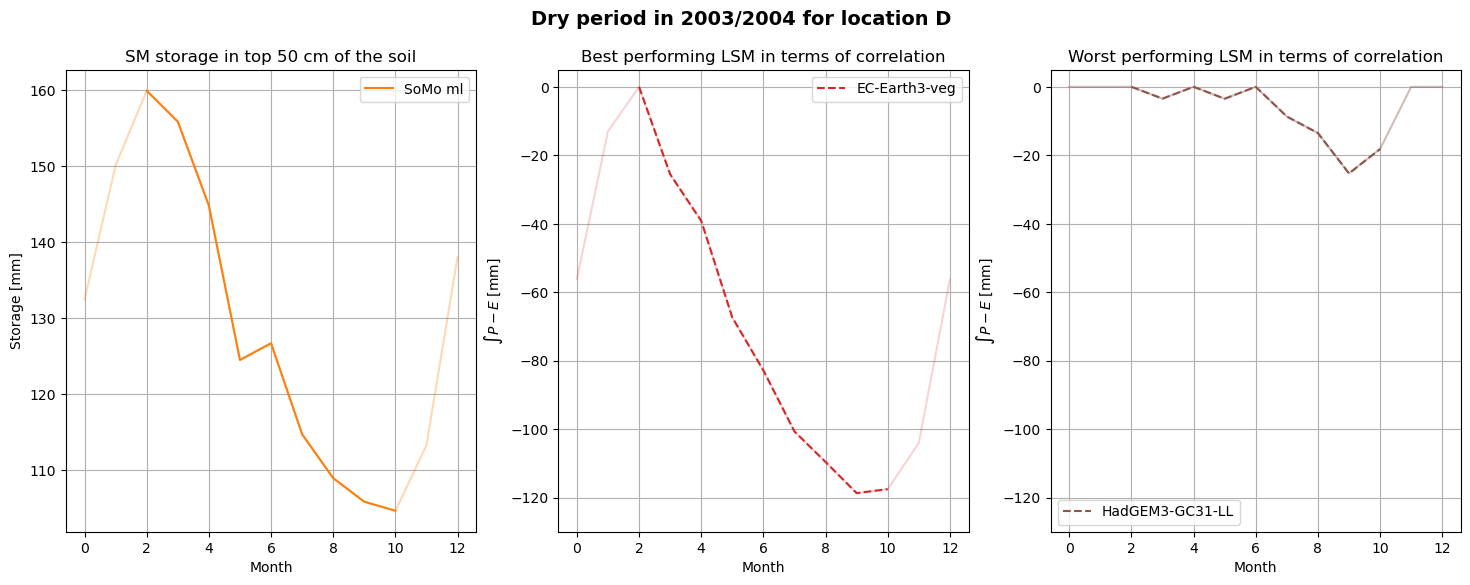

In [23]:
plt.figure(figsize = (18 , 6))

plt.subplot(131)
plt.plot(Storage[29:42] , color = 'C1' , alpha = 0.3)
plt.plot([2, 3 , 4 , 5 , 6 , 7 , 8 ,9 , 10] , Storage[31:40] , color = 'C1' , label = 'SoMo ml')
plt.title('SM storage in top 50 cm of the soil')
plt.xlabel('Month')
plt.ylabel('Storage [mm]')
#plt.xticks([0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13] , ['May' , 'Jun', 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec' , 'Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'June']) #Fix this for the right months
plt.grid()
plt.legend()

plt.subplot(132)
plt.plot(S_EC_Earth3_veg[29:42] , color = 'C3' , alpha = 0.2)
#plt.plot(S_FBP[31:40] , color = 'C3' , alpha = 0.2)
plt.plot([2,3 , 4 , 5 , 6 , 7 , 8 ,9 , 10 ] , S_EC_Earth3_veg[31:40] , color = 'C3' , label = 'EC-Earth3-veg' , linestyle = 'dashed')
#plt.plot([2 , 3 , 4 , 5 , 6 , 7 , 8] , S_FBP[28:35] , color = 'C3' , label = 'FBP')
plt.title('Best performing LSM in terms of correlation')
plt.ylabel(r'$\int P - E $ [mm]')
plt.xlabel('Month')
plt.ylim(-130 , 5)
#plt.xticks([0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13] , ['May' , 'Jun', 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec' , 'Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'June'])
plt.grid()
plt.legend()

plt.subplot(133)

plt.plot(S_HadGEM3_GC31_LL[29:42] , color = 'C5' , alpha = 0.4)
plt.plot([2,3 , 4 , 5 , 6 , 7 , 8 ,9 , 10 ] , S_HadGEM3_GC31_LL[31:40] , color = 'C5' , label = 'HadGEM3-GC31-LL' , linestyle = 'dashed')
plt.title('Worst performing LSM in terms of correlation')
plt.ylabel(r'$\int P - E $ [mm]')
#plt.xticks([0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13] , ['May' , 'Jun', 'Jul' , 'Aug' , 'Sep' , 'Oct' , 'Nov' , 'Dec' , 'Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'June'])
plt.xlabel('Month')
plt.ylim(-130 , 5)
plt.grid()
plt.legend();

plt.suptitle('Dry period in 2003/2004 for location D', fontsize = 14 ,fontweight = 'bold');
print()

In [24]:
print(f'The maximum decrease in storage in 2003/2004')

print('----' * 24)
print(f'The maximum decrease for  MIROC6          is equal to:           {S_MIROC6[31] - S_MIROC6[39]:.3f} mm')
print(f'The maximum decrease for  EC_Earth3_veg   is equal to:           {S_EC_Earth3_veg[31] - S_EC_Earth3_veg[39]:.3f} mm')
print(f'The maximum decrease for  UKESM1_0_LL     is equal to:           {S_UKESM1_0_LL[31] - S_UKESM1_0_LL[39]:.3f} mm')
print(f'The maximum decrease for  CESM2           is equal to:           {S_CESM2[31] - S_CESM2[39]:.3f} mm')
print(f'The maximum decrease for  CMCC-ESM2       is equal to:           {S_CMCC_ESM2[31] - S_CMCC_ESM2[39]:.3f} mm')
print(f'The maximum decrease for  E3SM-1-1        is equal to:           {S_E3SM_1_1[31] - S_E3SM_1_1[39]:.3f} mm')
print(f'The maximum decrease for  HadGEM3-GC31-LL is equal to:           {S_HadGEM3_GC31_LL[31] - S_HadGEM3_GC31_LL[39]:.3f} mm')
print(f'The maximum decrease for  IPSL-CM6A-LR    is equal to:           {S_IPSL_CM6A_LR[31] - S_IPSL_CM6A_LR[39]:.3f} mm')
print('----' * 24)
print(f'The maximum decrease for  FBP             is equal to:           {S_FBP[31] - S_FBP[39]:.3f} mm')
print(f'The maximum decrease for  DOLCE v3        is equal to:           {S_DOLCE_v3[31] - S_DOLCE_v3[39]:.3f} mm')
print('----' * 24)
print()

The maximum decrease in storage in 2003/2004
------------------------------------------------------------------------------------------------
The maximum decrease for  MIROC6          is equal to:           143.136 mm
The maximum decrease for  EC_Earth3_veg   is equal to:           117.565 mm
The maximum decrease for  UKESM1_0_LL     is equal to:           26.481 mm
The maximum decrease for  CESM2           is equal to:           115.382 mm
The maximum decrease for  CMCC-ESM2       is equal to:           81.614 mm
The maximum decrease for  E3SM-1-1        is equal to:           92.962 mm
The maximum decrease for  HadGEM3-GC31-LL is equal to:           18.167 mm
The maximum decrease for  IPSL-CM6A-LR    is equal to:           70.503 mm
------------------------------------------------------------------------------------------------
The maximum decrease for  FBP             is equal to:           143.514 mm
The maximum decrease for  DOLCE v3        is equal to:           119.192 mm
------

In [25]:
"""Extracting the dry months from the storage"""

"""Manually selecting the three dry periods"""

ADM_index = [31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62]

#All dry months from three selected periods

ADM_SoMo = np.zeros(len(ADM_index))

for j in range(len(ADM_index)):
    ADM_SoMo[j] = Storage[ADM_index[j]]

t = len(ADM_index)

model_ADM = ['ADM_DOLCE_v3', 'ADM_FBP', 'ADM_UKESM1_0_LL', 'ADM_EC_Earth3_veg', 'ADM_CESM2', 'ADM_CMCC_ESM2', 'ADM_E3SM_1_1', 'ADM_HadGEM3_GC31_LL', 'ADM_IPSL_CM6A_LR', 'ADM_MIROC6']

for model in model_ADM:
    exec(f"{model} = np.zeros(t)")
    for i in range(t):
        exec(f"{model}[i] = S_{model[4:]}[ADM_index[i]]")

0 0.9760296624774342
1 0.8830371967205869
2 0.7398973094184895
3 0.9804396510627212
4 0.9476750329604654
5 0.9524341472440035
6 0.9498605315358528
7 0.6248470895340953
8 0.8829042939493016
9 0.8532311950045465


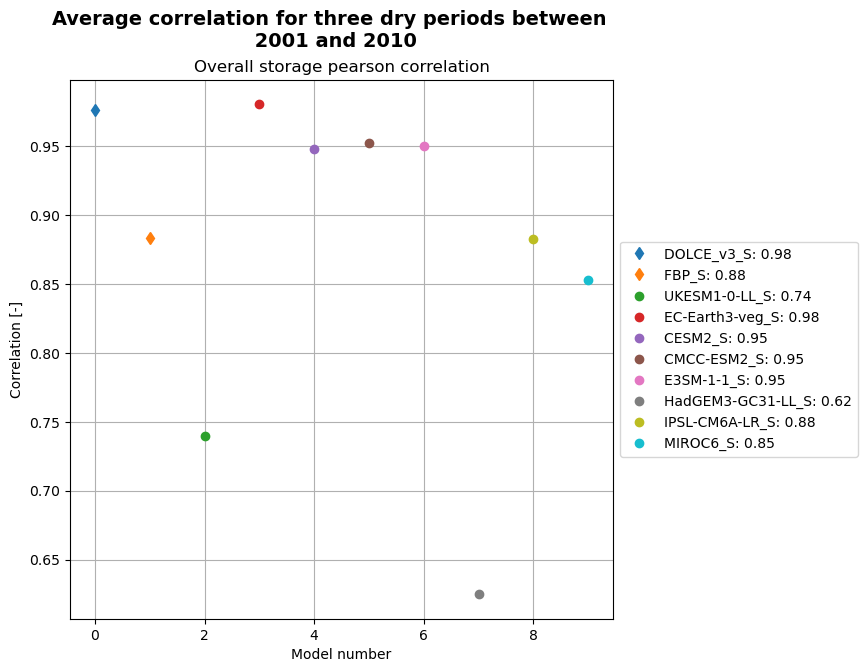

In [26]:
plt.figure(figsize = (7, 7))

label = ['DOLCE_v3_S' , 'FBP_S' ,'UKESM1-0-LL_S' , 'EC-Earth3-veg_S' , 'CESM2_S' , 'CMCC-ESM2_S' , 'E3SM-1-1_S' , 'HadGEM3-GC31-LL_S' , 'IPSL-CM6A-LR_S' , 'MIROC6_S']
ADM = [ADM_DOLCE_v3 , ADM_FBP  , ADM_UKESM1_0_LL , ADM_EC_Earth3_veg , ADM_CESM2 , ADM_CMCC_ESM2 , ADM_E3SM_1_1 , ADM_HadGEM3_GC31_LL , ADM_IPSL_CM6A_LR , ADM_MIROC6]

p = np.zeros(len(ADM))
b3 = [0 , 9 , 18] #boundaries of dry periods within the ADM array so that the step between dry periods isn't included in the correlation analysis
b4 = [9 , 18 , 27]

for j in range(len(ADM)):
    for i in range(len(b3)):
        x = ADM_SoMo[b3[i]:b4[i]]
        y = ADM[j][b3[i]:b4[i]]
        pearsonr = scipy.stats.pearsonr(x, y)
        p[j] += pearsonr[0]
    plt.plot(j , p[j]/len(b3) , marker = marker[j] , label = f'{label[j]}: {p[j]/len(b3):.2f}'  , linestyle = (0 , (0 , 100)))
    print(j , p[j]/len(b3))
    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Overall storage pearson correlation')
plt.ylabel('Correlation [-]')
plt.xlabel('Model number')
plt.grid()

plt.suptitle('Average correlation for three dry periods between \n 2001 and 2010' , fontsize = 14 ,fontweight = 'bold');
#plt.ylim(0.5 , 0.8);

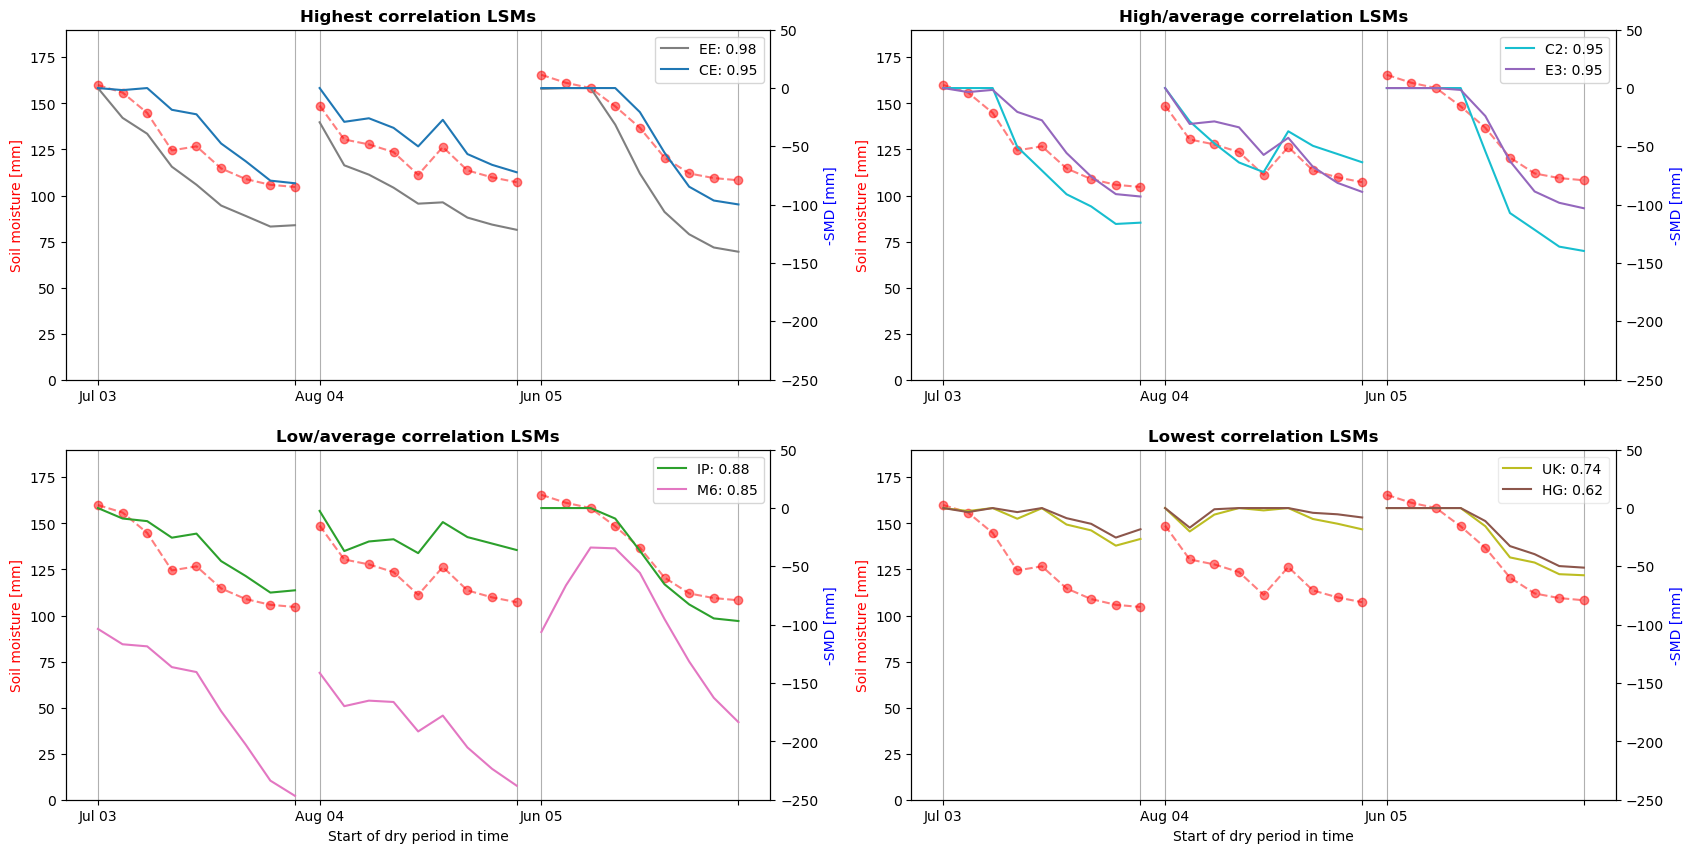

In [27]:
"""Plots for the three dry periods"""

"""Manually putting in the xticks and the scales, the scales should be sit in a way that the SoMo.ml and the LSMs overlap at the start of the dry periods"""

"""Manually grouping the LSMs in High, Average and Low correlation groups"""

fig, axs = plt.subplots(2 , 2 , figsize = (20 , 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax1 = ax.twinx()
    if i == 0:
        ax.plot(ADM_SoMo[b3[0]:b4[0]] ,  'ro--' , alpha = 0.5 , label = 'SO SM')
        ax.plot(np.arange(b3[1] , b4[1] , 1) ,ADM_SoMo[b3[1]:b4[1]] ,  'ro--' , alpha = 0.5)
        ax.plot(np.arange(b3[2] , b4[2] , 1) ,ADM_SoMo[b3[2]:b4[2]] ,  'ro--' , alpha = 0.5)
        
        #ax1.plot(ADM_DOLCE_v3 , color = 'C1' , alpha = 0.9 , label = f'DOLCE v3: {p[0]/len(b3):.2f}')
        #ax1.plot(ADM_FBP , color = 'C2' , label = f'FBP : {p[1]/len(b3):.2f}')
        
        ax1.plot(ADM_EC_Earth3_veg[b3[0]:b4[0]] , label = f'EE: {p[3]/len(b3):.2f}' , color = 'C7')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_EC_Earth3_veg[b3[1]:b4[1]] , color = 'C7')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_EC_Earth3_veg[b3[2]:b4[2]] , color = 'C7')
        
        ax1.plot(ADM_CMCC_ESM2[b3[0]:b4[0]] , label = f'CE: {p[5]/len(b3):.2f}' , color = 'C10')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_CMCC_ESM2[b3[1]:b4[1]] , color = 'C10')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_CMCC_ESM2[b3[2]:b4[2]] , color = 'C10')
        
        ax.set_title(r'Highest correlation LSMs' , fontweight = 'bold')
        ax.set_ylabel('Soil moisture [mm]', color='r')
        #ax.set_xlabel('Time [months]')
        ax.set_ylim(0 , 190)
        ax1.set_ylabel('-SMD [mm]', color='b')
        ax1.set_ylim(-250 , 50)
        plt.xticks( [0 , 8 , 9 , 17 , 18 , 26] ,['Jul 03' , '' , 'Aug 04' , '' , 'Jun 05' , ''])
        #plt.grid()
        plt.legend();
    elif i == 1:
        ax.plot(ADM_SoMo[b3[0]:b4[0]] ,  'ro--' , alpha = 0.5 , label = 'SO SM')
        ax.plot(np.arange(b3[1] , b4[1] , 1) ,ADM_SoMo[b3[1]:b4[1]] ,  'ro--' , alpha = 0.5)
        ax.plot(np.arange(b3[2] , b4[2] , 1) ,ADM_SoMo[b3[2]:b4[2]] ,  'ro--' , alpha = 0.5)
        
        ax1.plot(ADM_CESM2[b3[0]:b4[0]] , label = f'C2: {p[4]/len(b3):.2f}' , color = 'C9')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_CESM2[b3[1]:b4[1]] , color = 'C9')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_CESM2[b3[2]:b4[2]] , color = 'C9')
        
        ax1.plot(ADM_E3SM_1_1[b3[0]:b4[0]] , label = f'E3: {p[6]/len(b3):.2f}' , color = 'C4')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_E3SM_1_1[b3[1]:b4[1]] , color = 'C4')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_E3SM_1_1[b3[2]:b4[2]] , color = 'C4')
        
        ax.set_title(r'High/average correlation LSMs' , fontweight = 'bold')
        ax.set_ylabel('Soil moisture [mm]', color='r')
        #ax.set_xlabel('Time [months]')
        ax.set_ylim(0 , 190)
        ax1.set_ylabel('-SMD [mm]', color='b')
        ax1.set_ylim(-250 , 50)
        plt.xticks( [0 , 8 , 9 , 17 , 18 , 26] ,['Jul 03' , '' , 'Aug 04' , '' , 'Jun 05' , ''])
       # plt.grid()
        plt.legend();
    elif i == 2:
        ax.plot(ADM_SoMo[b3[0]:b4[0]] ,  'ro--' , alpha = 0.5 , label = 'SO SM')
        ax.plot(np.arange(b3[1] , b4[1] , 1) ,ADM_SoMo[b3[1]:b4[1]] ,  'ro--' , alpha = 0.5)
        ax.plot(np.arange(b3[2] , b4[2] , 1) ,ADM_SoMo[b3[2]:b4[2]] ,  'ro--' , alpha = 0.5)
        
        ax1.plot(ADM_IPSL_CM6A_LR[b3[0]:b4[0]] , label = f'IP: {p[8]/len(b3):.2f}' , color = 'C2')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_IPSL_CM6A_LR[b3[1]:b4[1]] , color = 'C2')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_IPSL_CM6A_LR[b3[2]:b4[2]] , color = 'C2')
        
                
        ax1.plot(ADM_MIROC6[b3[0]:b4[0]] , label = f'M6: {p[9]/len(b3):.2f}' , color = 'C6')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_MIROC6[b3[1]:b4[1]] , color = 'C6')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_MIROC6[b3[2]:b4[2]] , color = 'C6')
        
        ax.set_title(r'Low/average correlation LSMs' , fontweight = 'bold')
        ax.set_ylabel('Soil moisture [mm]', color='r')
        ax.set_xlabel('Start of dry period in time')
        ax.set_ylim(0 , 190)
        ax1.set_ylabel('-SMD [mm]', color='b')
        ax1.set_ylim(-250 , 50)
        plt.xticks( [0 , 8 , 9 , 17 , 18 , 26] ,['Jul 03' , '' , 'Aug 04' , '' , 'Jun 05' , ''])
        #plt.grid()
        plt.legend();
    else:
        ax.plot(ADM_SoMo[b3[0]:b4[0]] ,  'ro--' , alpha = 0.5 , label = 'SO SM')
        ax.plot(np.arange(b3[1] , b4[1] , 1) ,ADM_SoMo[b3[1]:b4[1]] ,  'ro--' , alpha = 0.5)
        ax.plot(np.arange(b3[2] , b4[2] , 1) ,ADM_SoMo[b3[2]:b4[2]] ,  'ro--' , alpha = 0.5)
        
        ax1.plot(ADM_UKESM1_0_LL[b3[0]:b4[0]] , label = f'UK: {p[2]/len(b3):.2f}' , color = 'C8')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_UKESM1_0_LL[b3[1]:b4[1]] , color = 'C8')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_UKESM1_0_LL[b3[2]:b4[2]] , color = 'C8')
        
        ax1.plot(ADM_HadGEM3_GC31_LL[b3[0]:b4[0]] , label = f'HG: {p[7]/len(b3):.2f}' , color = 'C5')
        ax1.plot(np.arange(b3[1] , b4[1] , 1) , ADM_HadGEM3_GC31_LL[b3[1]:b4[1]] , color = 'C5')
        ax1.plot(np.arange(b3[2] , b4[2] , 1) , ADM_HadGEM3_GC31_LL[b3[2]:b4[2]] , color = 'C5')
        
        ax.set_title(r'Lowest correlation LSMs', fontweight = 'bold')
        ax.set_ylabel('Soil moisture [mm]', color='r')
        ax.set_xlabel('Start of dry period in time')
        ax.set_ylim(0 , 190)
        ax1.set_ylabel('-SMD [mm]', color='b')
        ax1.set_ylim(-250 , 50)
        plt.xticks( [0 , 8 , 9 , 17 , 18 , 26] ,['Jul 03' , '' , 'Aug 04' , '' , 'Jun 05' , ''])
        #plt.grid()
        plt.legend(framealpha = 0.4);
    ax.grid(True , axis = 'x')

# Show plot
plt.show()

In [28]:
"""Comparing Mrsol to P - ET"""

"""Data"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/LS3MIP/mrsol/Regions/'

CESM2 = xr.open_dataset(home + 'mrsol_Emon_CESM2_land-hist_r1i1p1f1_2001-2010_SA.nc' , engine = 'netcdf4')
CMCC_ESM2 = xr.open_dataset(home + 'mrsol_Emon_CMCC-ESM2_land-hist_r1i1p1f1_2001-2010_SA.nc' , engine = 'netcdf4')
HadGEM3_GC31_LL = xr.open_dataset(home + 'mrsol_Emon_HadGEM3-GC31-LL_land-hist_r1i1p1f3_2001-2010_SA.nc' , engine = 'netcdf4')
IPSL_CM6A_LR = xr.open_dataset(home + 'mrsol_Emon_IPSL-CM6A-LR_land-hist_r1i1p1f1_2001-2010_SA.nc' , engine = 'netcdf4')
MIROC6 = xr.open_dataset(home + 'mrsol_Emon_MIROC6_land-hist_r1i1p1f1_2001-2010_SA.nc' , engine = 'netcdf4')
UKESM1_0_LL = xr.open_dataset(home + 'mrsol_Emon_UKESM1-0-LL_land-hist_r1i1p1f2_2001-2010_SA.nc' , engine = 'netcdf4')

In [29]:
"""Until max thickness of the layer"""

"""Mrsol"""


t = 120
Mrsol_CESM2_mean = np.zeros(t)
Mrsol_CMCC_ESM2_mean = np.zeros(t)
Mrsol_HadGEM3_GC31_LL_mean = np.zeros(t)
Mrsol_IPSL_CM6A_LR_mean = np.zeros(t)
Mrsol_UKESM1_0_LL_mean = np.zeros(t)
Mrsol_MIROC6_mean = np.zeros(t)

for i in range(t):
    Mrsol_CESM2_mean[i] = CESM2.mrsol[i , 0:20].mean()*20
    Mrsol_CMCC_ESM2_mean[i] = CMCC_ESM2.mrsol[i , 0:9].mean()*15
    Mrsol_HadGEM3_GC31_LL_mean[i] = HadGEM3_GC31_LL.mrsol[i , 0:4].mean() * 4
    Mrsol_IPSL_CM6A_LR_mean[i] = IPSL_CM6A_LR.mrsol[i , 0:11].mean() * 11
    Mrsol_MIROC6_mean[i] = MIROC6.mrsol[i , 0:6].mean() * 6
    Mrsol_UKESM1_0_LL_mean[i] = UKESM1_0_LL.mrsol[i , 0:4].mean() * 4

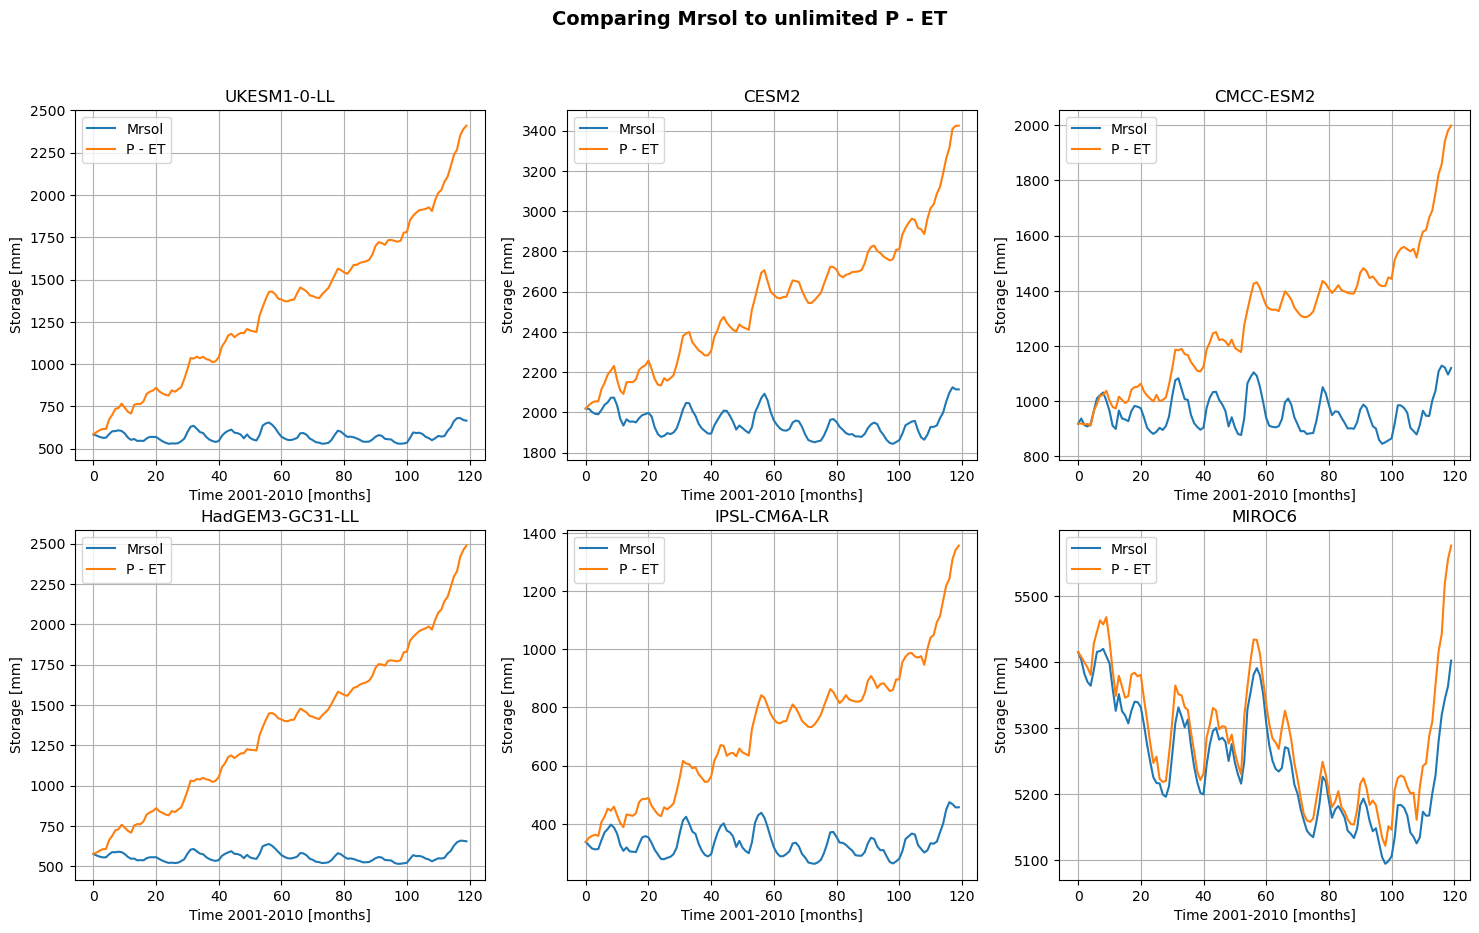

In [30]:
"""Storage"""

#At t = 0 setting the storage even with the mrsol data


t = 120

S1_UKESM1_0_LL = np.zeros(t)
S1_CESM2 = np.zeros(t)
S1_CMCC_ESM2 = np.zeros(t)
S1_HadGEM3_GC31_LL = np.zeros(t)
S1_IPSL_CM6A_LR = np.zeros(t)
S1_MIROC6 = np.zeros(t)

for i in range(t):
    S1_UKESM1_0_LL[i] = S1_UKESM1_0_LL[i - 1] + (P_mean[i] - ET_mean_UKESM1_0_LL[i])
    S1_CESM2[i] = S1_CESM2[i - 1] + (P_mean[i] - ET_mean_CESM2[i])
    S1_CMCC_ESM2[i] = S1_CMCC_ESM2[i - 1] + (P_mean[i] - ET_mean_CMCC_ESM2[i])
    S1_HadGEM3_GC31_LL[i] = S1_HadGEM3_GC31_LL[i - 1] + (P_mean[i] - ET_mean_HadGEM3_GC31_LL[i])
    S1_IPSL_CM6A_LR[i] =  S1_IPSL_CM6A_LR[i - 1] + (P_mean[i] - ET_mean_IPSL_CM6A_LR[i])
    S1_MIROC6[i] = S1_MIROC6[i - 1] + (P_mean[i] - ET_mean_MIROC6[i])
    
    S1_UKESM1_0_LL[0] = Mrsol_UKESM1_0_LL_mean[0]
    S1_CESM2[0] = Mrsol_CESM2_mean[0]
    S1_CMCC_ESM2[0] = Mrsol_CMCC_ESM2_mean[0]
    S1_HadGEM3_GC31_LL[0] = Mrsol_HadGEM3_GC31_LL_mean[0]
    S1_IPSL_CM6A_LR[0] = Mrsol_IPSL_CM6A_LR_mean[0]
    S1_MIROC6[0] = Mrsol_MIROC6_mean[0]
     
label = ['UKESM1-0-LL' , 'CESM2' , 'CMCC-ESM2' , 'HadGEM3-GC31-LL' , 'IPSL-CM6A-LR' , 'MIROC6']
S1 = [S1_UKESM1_0_LL  , S1_CESM2, S1_CMCC_ESM2 , S1_HadGEM3_GC31_LL , S1_IPSL_CM6A_LR , S1_MIROC6]
Mrsol = [Mrsol_UKESM1_0_LL_mean , Mrsol_CESM2_mean , Mrsol_CMCC_ESM2_mean , Mrsol_HadGEM3_GC31_LL_mean , Mrsol_IPSL_CM6A_LR_mean , Mrsol_MIROC6_mean]
    
plt.figure(figsize = (18 , 10))

for i in range(len(S1)):
    plt.subplot(2 , 3 , i + 1)
    plt.title(label[i])
    plt.plot(Mrsol[i] , label = 'Mrsol')
    plt.ylabel('Storage [mm]')
    plt.xlabel('Time 2001-2010 [months]')
    plt.grid()
    plt.plot(S1[i] , label = 'P - ET')
    
    plt.legend()
    
plt.suptitle('Comparing Mrsol to unlimited P - ET' , fontsize = 14 , fontweight = 'bold');

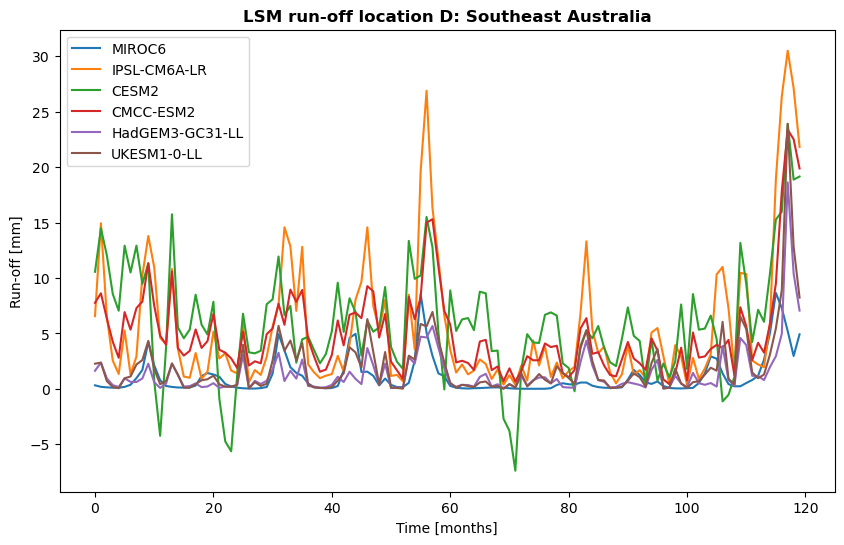

In [31]:
"""Run-off"""


plt.figure(figsize = (10 , 6))

R = [R_MIROC6, R_IPSL_CM6A_LR, R_CESM2, R_CMCC_ESM2 , R_HadGEM3_GC31_LL , R_UKESM1_0_LL]
label = ['MIROC6', 'IPSL-CM6A-LR', 'CESM2', 'CMCC-ESM2' , 'HadGEM3-GC31-LL' , 'UKESM1-0-LL']

for i in range(len(R)):
    plt.plot(R[i] , label = label[i])
    

plt.title('LSM run-off location D: Southeast Australia' , fontweight = 'bold')
plt.ylabel('Run-off [mm]')
plt.xlabel('Time [months]')
plt.legend()

In [32]:
"""RUN-OFF"""

R = [R_MIROC6, R_IPSL_CM6A_LR, R_CESM2, R_CMCC_ESM2 , R_HadGEM3_GC31_LL , R_UKESM1_0_LL , R_EC_Earth3_veg , R_E3SM_1_1]
label = ['MIROC6', 'IPSL-CM6A-LR', 'CESM2', 'CMCC-ESM2' , 'HadGEM3-GC31-LL' , 'UKESM1-0-LL' , 'EC-Earth3-veg' , 'E3SM-1-1']

#2005/2006

print()

print('2005/2006')
print()

for i in range(len(R)):
    I = R[i][54].mean() + R[i][55].mean() + R[i][56].mean() + R[i][57].mean() + R[i][58].mean() + R[i][59].mean() + R[i][60].mean()+ R[i][61].mean() + R[i][62].mean()
    print(f'{label[i]}: {float(I):.3f}')
    
#2007

print()
print('2003/2004')
print()

for i in range(len(R)):
    I = R[i][31].mean() + R[i][32].mean() + R[i][33].mean() + R[i][34].mean() + R[i][35].mean() + R[i][36].mean() + R[i][37].mean() + R[i][38].mean() + R[i][39].mean() 
    print(f'{label[i]}: {float(I):.3f}')


2005/2006

MIROC6: 22.099
IPSL-CM6A-LR: 91.949
CESM2: 73.896
CMCC-ESM2: 73.642
HadGEM3-GC31-LL: 23.887
UKESM1-0-LL: 28.895
EC-Earth3-veg: 28.322
E3SM-1-1: 91.041

2003/2004

MIROC6: 13.778
IPSL-CM6A-LR: 60.742
CESM2: 46.579
CMCC-ESM2: 49.890
HadGEM3-GC31-LL: 9.880
UKESM1-0-LL: 20.905
EC-Earth3-veg: 18.504
E3SM-1-1: 66.092


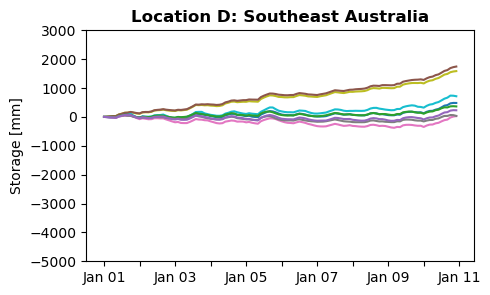

In [33]:
"""WB"""

models_WB = ['S_UKESM1_0_LL', 'S_CESM2', 'S_CMCC_ESM2', 'S_HadGEM3_GC31_LL', 'S_IPSL_CM6A_LR', 'S_MIROC6' , 'S_EC_Earth3_veg' , 'S_E3SM_1_1']

for model in models_WB:
    exec(f"{model} = np.zeros(t)") #Initialize all models with zeros
    for i in range(t):
        exec(f"{model}[i] = {model}[i - 1] + (P_mean[i] - ET_mean_{model[2:]}[i] - R_{model[2:]}[i])")
        exec(f"{model}[0] = 0")

plt.figure(figsize = (5 , 3))
plt.ylabel('Storage [mm]')
plt.plot(S_UKESM1_0_LL , label = 'UKESM1-0-LL' , color = 'C8')
plt.plot(S_CESM2 , label = 'CESM2' , color = 'C9')
plt.plot(S_CMCC_ESM2 , label = 'CMCC-ESM2' , color = 'C10')
plt.plot(S_HadGEM3_GC31_LL , label = 'HadGEM3-GC31-LL' , color = 'C5')
plt.plot(S_IPSL_CM6A_LR , label = 'IPSL-CM6A-LR' , color = 'C2')
plt.plot(S_MIROC6 , label = 'MIROC6' , color = 'C6')
plt.plot(S_EC_Earth3_veg , label = 'EC-Earth3-veg' , color = 'C7')
plt.plot(S_E3SM_1_1 , label = 'E3SM-1-1' , color = 'C4')
#plt.xlabel('Date')
plt.ylim(-5000 , 3000)
plt.title('Location D: Southeast Australia' , fontweight = 'bold')
plt.xticks(np.arange(0 , 121 , 12) , ['Jan 01' , '' ,'Jan 03' ,'' ,'Jan 05' ,'' ,'Jan 07' ,'' ,'Jan 09' ,'' , 'Jan 11']);
#plt.grid()
#plt.legend();

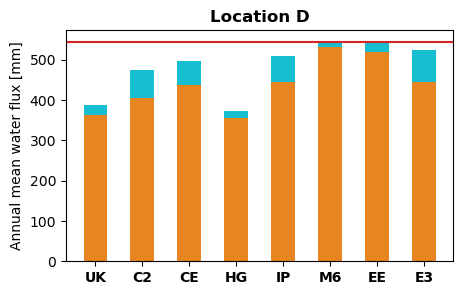

In [34]:
plt.figure(figsize = (5 , 3))

for model, i in zip(models_WB , np.arange(0, 8, 1)):
    exec(f"plt.bar(i, ET_mean_{model[2:]}.mean() * 12 + R_{model[2:]}.mean() * 12, width=0.5, color='C9')")
    exec(f"plt.bar(i, ET_mean_{model[2:]}.mean() * 12, width=0.5, color='C1'  , alpha = 0.9)")

plt.axhline(y=p_01_10/10, color='C3', label='Annual P')
plt.title('Location D', fontweight='bold')
plt.ylabel('Annual mean water flux [mm]')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['UK', 'C2', 'CE', 'HG', 'IP', 'M6', 'EE', 'E3'], fontweight='bold');

# Add legend
#plt.legend(['Annual P', 'Annual R', 'Annual E'], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

/home/pdenblaauwen/miniconda3/envs/ewatercycle/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


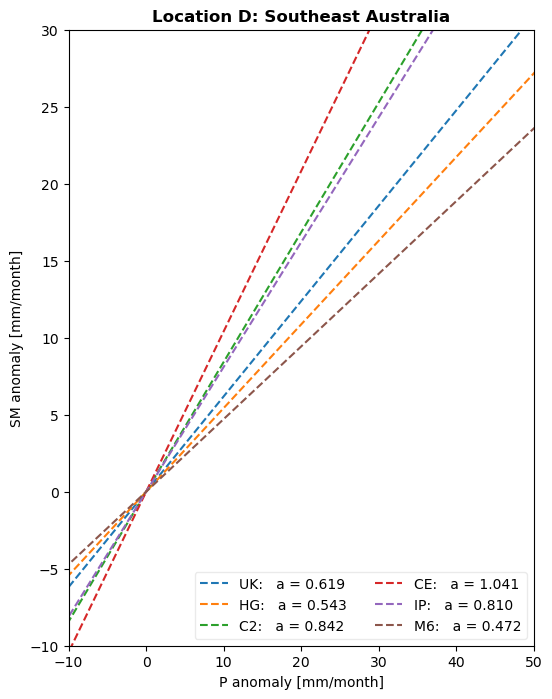

In [35]:
"""P - SM response anomolies"""

"""Mrsol"""

SM_mean = Mrsol
SM_pm_mean = np.zeros((6 , 12))

for j in range(len(SM_mean)):
    for i in range(12):
        #Array per month average
        SM_pm_mean[j , i] = np.mean([SM_mean[j][i] , SM_mean[j][i + 12] , SM_mean[j][i + 24] ,  SM_mean[j][i+36] , 
        SM_mean[j][i + 48] , SM_mean[j][i + 60] , SM_mean[j][i + 72] , SM_mean[j][i + 84] , SM_mean[j][i + 96] , 
        SM_mean[j][i + 108]])

SM_an = np.zeros((10 , 120))
mpy = np.arange(0 , 120 , 12)

for m in range(len(SM_mean)):
    for j in range(len(mpy)):   
        for i in range(12):
            SM_an[m][mpy[j] + i] = SM_mean[m][mpy[j]+i] - SM_pm_mean[m][i]
            
"""Linear function"""

d = {'P_mean': P_an, 'UKESM1-0-LL' : SM_an[0] , 'CESM2' : SM_an[1] , 'CMCC-ESM2':SM_an[2] 
     , 'HadGEM3-GC31-LL' : SM_an[3] , 'IPSL-CM6A-LR':SM_an[4] , 'MIROC6':SM_an[5]}
df = pd.DataFrame(d)
df = df.sort_values(by = ['P_mean'])

def func(x, a , b):
    return a * x + b

label_a = ['UK'  ,  'HG' , 'C2' , 'CE' , 'IP' , 'M6']
label = ['UKESM1-0-LL'  ,  'HadGEM3-GC31-LL' , 'CESM2' , 'CMCC-ESM2' , 'IPSL-CM6A-LR' , 'MIROC6']
y = df['UKESM1-0-LL'] , df['HadGEM3-GC31-LL'] , df['CESM2'] , df['CMCC-ESM2'] , df['IPSL-CM6A-LR'] , df['MIROC6']
linestyle = ['dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed' , 'dashed']
S = np.zeros(len(label))
a = np.zeros(len(label))

plt.figure(figsize = (6 , 8))

for i in range(len(label)):
    xdata = df['P_mean']
    ydata = y[i]
    popt , pcov  = curve_fit(func , xdata, ydata)
    S[i] = func(xdata[0] , *popt)
    a[i] = popt[0]
    plt.plot(xdata , func(xdata, *popt) , label = f'{label_a[i]}:   a = {a[i]:.3f}' , linestyle = linestyle[i]);


#Adjust xlim and ylim manually if needed    

plt.title('Location D: Southeast Australia' , fontweight = 'bold')
plt.ylim(-10 , 30)
#plt.grid()
plt.xlim(-10 , 50)
plt.ylabel('SM anomaly [mm/month]')
plt.xlabel('P anomaly [mm/month]')
plt.legend(framealpha = 0.4 , ncols = 2);